## Blood Pressure estimation via the PPG; model training and performance measurement 
> we are curious about the methodology of estimating blood pressure using PPG to predict Systolic and Diaslotic blood pressure.

+++++

> data importing 

- already main trimmed and prepared dataset is considered.  For using your dataframe from under dataframes/df_subject_{n}_segment_{m}_row_{}_peak_by_peak_120_sampled ; 

If you want to use already prepared dataset; you can directly consider the dataset that under ./data/preprocessing_ready_set/df_subject_{n}_segment_{m}_row_{}_peak_by_peak_120_sampled.

In [1]:
import pandas as pd

# Load the summary subject/segment information DataFrame
df = pd.read_pickle("./data/dataframes/df_subject_5_segment_5_row_8721_peak_by_peak_120_sampled.pkl")


In [2]:
df

ppg_norm_120  \
0     [1.0, 0.988420844078064, 0.9576899409294128, 0...   
1     [1.0, 0.9818533658981323, 0.9489679336547852, ...   
2     [0.879189670085907, 0.8736501932144165, 0.8596...   
3     [0.8823926448822021, 0.8701218366622925, 0.836...   
4     [1.0, 0.9913243055343628, 0.9633445143699646, ...   
...                                                 ...   
8716  [1.0, 0.9867700338363647, 0.9550496935844421, ...   
8717  [0.8452457785606384, 0.8301437497138977, 0.798...   
8718  [0.9422916769981384, 0.9343175292015076, 0.911...   
8719  [1.0, 0.9892218708992004, 0.9576123952865601, ...   
8720  [1.0, 0.9880400896072388, 0.9617972373962402, ...   

                                            ppg_raw_120         sbp  \
0     [0.05315064266324043, 0.05213972553610802, 0.0...  104.687500   
1     [0.05082251504063606, 0.049274664372205734, 0....  103.906250   
2     [0.042301520705223083, 0.04179579019546509, 0....  102.343750   
3     [0.05396733060479164, 0.05287180840969086, 0.0...  101.562500   
4     [0.06526798754930496, 0.06434018164873123, 0.0...   91.406250   
...                                                 ...         ...   
8716  [0.9519408345222473, 0.9318029284477234, 0.883...  134.565506   
8717  [0.8281505703926086, 0.8048844337463379, 0.755...  137.935745   
8718  [1.0780895948410034, 1.0626519918441772, 1.018...  148.486084   
8719  [1.2053706645965576, 1.1875877380371094, 1.135...  134.907410   
8720  [0.920042872428894, 0.898963987827301, 0.85271...  139.742981   

            dbp    segment_id  \
0     51.562500  3207225_0005   
1     50.781250  3207225_0005   
2     50.781250  3207225_0005   
3     46.093750  3207225_0005   
4     46.093750  3207225_0005   
...         ...           ...   
8716  60.175938  3208137_0010   
8717  58.222172  3208137_0010   
8718  48.795261  3208137_0010   
8719  56.121876  3208137_0010   
8720  56.073032  3208137_0010   

                                                abp_raw  
0     [65.625, 67.1875, 67.96875, 68.75, 68.75, 68.7...  
1     [66.40625, 67.96875, 68.75, 69.53125, 69.53125...  
2     [66.40625, 67.1875, 67.96875, 68.75, 68.75, 68...  
3     [67.1875, 67.96875, 68.75, 68.75, 68.75, 68.75...  
4     [64.0625, 64.84375, 64.84375, 64.84375, 64.843...  
...                                                 ...  
8716  [67.30717468261719, 66.4768295288086, 65.69532...  
8717  [64.81612396240234, 63.93693161010742, 63.1554...  
8718  [65.10919189453125, 64.37652587890625, 63.6927...  
8719  [66.67220306396484, 65.79300689697266, 64.9138...  
8720  [65.7441635131836, 64.913818359375, 64.1323089...  

[8721 rows x 6 columns]

> CI check on the ABP data

- that make very harsh elimination compared with the others so this make the overall formation pretty harsh, maybe must be revised 

In [3]:
# # CI info on that point 

import json
import numpy as np
import pandas as pd

# Recompute per-window mean ABP
df['mean_abp'] = df['abp_raw'].apply(np.mean)

n = len(df)
mean_all = df['mean_abp'].mean()
std_all = df['mean_abp'].std(ddof=1)

# (1) 95% CI for the GLOBAL MEAN (strict; uses SE = std/sqrt(n))
z = 2.5
se = std_all / np.sqrt(n)
ci_mean_lower = mean_all - z * se
ci_mean_upper = mean_all + z * se

# (2) 95% RANGE for INDIVIDUAL WINDOWS (outlier filter; no sqrt(n))
range95_lower = mean_all - z * std_all
range95_upper = mean_all + z * std_all

# How many rows would pass each criterion (informational)
kept_global_CI = ((df['mean_abp'] >= ci_mean_lower) & (df['mean_abp'] <= ci_mean_upper)).sum()
kept_window_range = ((df['mean_abp'] >= range95_lower) & (df['mean_abp'] <= range95_upper)).sum()

# Save to JSON for reuse
intervals = {
    "n_windows": int(n),
    "mean_of_window_means": float(mean_all),
    "std_of_window_means": float(std_all),
    "z_for_95pct": float(z),
    "global_mean_CI_95": {"lower": float(ci_mean_lower), "upper": float(ci_mean_upper)},
    "window_means_range_95": {"lower": float(range95_lower), "upper": float(range95_upper)},
    "rows_within_global_mean_CI": int(kept_global_CI),
    "rows_within_window_means_range": int(kept_window_range)
}
with open("./abp_intervals.json", "w") as f:
    json.dump(intervals, f, indent=2)

# Display values directly
intervals


{'n_windows': 8721,
 'mean_of_window_means': 75.50584891018418,
 'std_of_window_means': 22.91326877069068,
 'z_for_95pct': 2.5,
 'global_mean_CI_95': {'lower': 74.89244870799313, 'upper': 76.11924911237524},
 'window_means_range_95': {'lower': 18.222676983457482,
  'upper': 132.78902083691088},
 'rows_within_global_mean_CI': 143,
 'rows_within_window_means_range': 6174}

In [4]:
import numpy as np

# Step 1: Calculate the mean ABP for each row
df['mean_abp'] = df['abp_raw'].apply(np.mean)

# Step 2: Calculate the tolerance bounds for window means (z=2.5 for ~99%)
z = 2.5
mean_all = df['mean_abp'].mean()
std_all = df['mean_abp'].std()
lower_bound = mean_all - z * std_all
upper_bound = mean_all + z * std_all

# Step 3: Filter the dataset to keep only rows within the bounds
df = df[(df['mean_abp'] >= lower_bound) & (df['mean_abp'] <= upper_bound)]

# Step 4: Remove the 'mean_abp' column if no longer needed
df = df.drop(columns=['mean_abp'])


------------------------------------


### the amount of the rows per the subject and the overall formation on the data

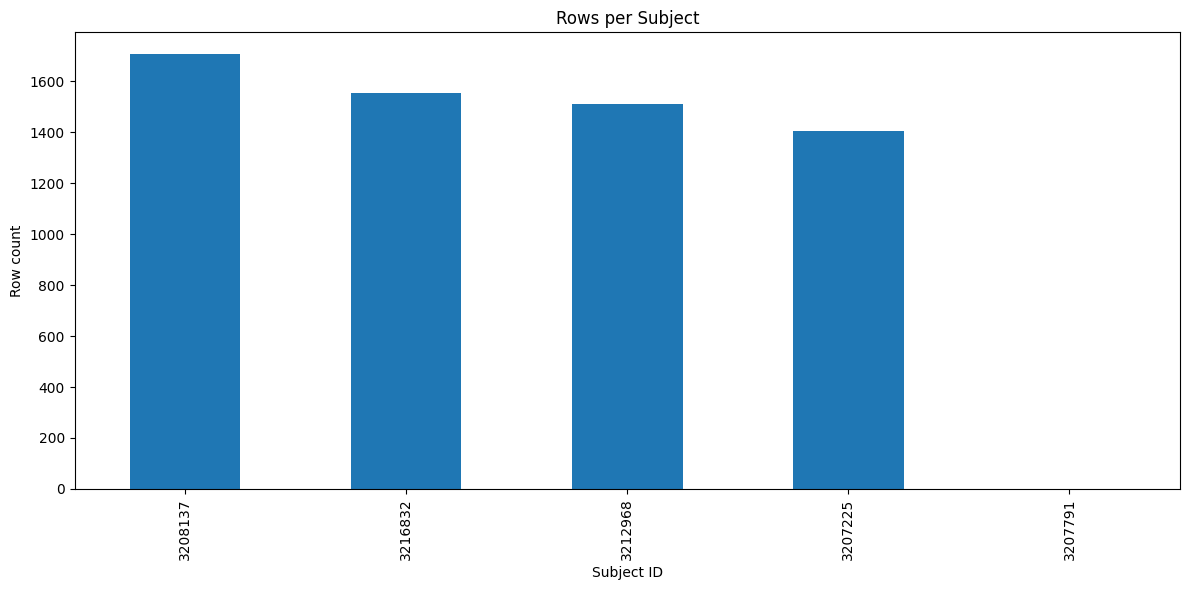

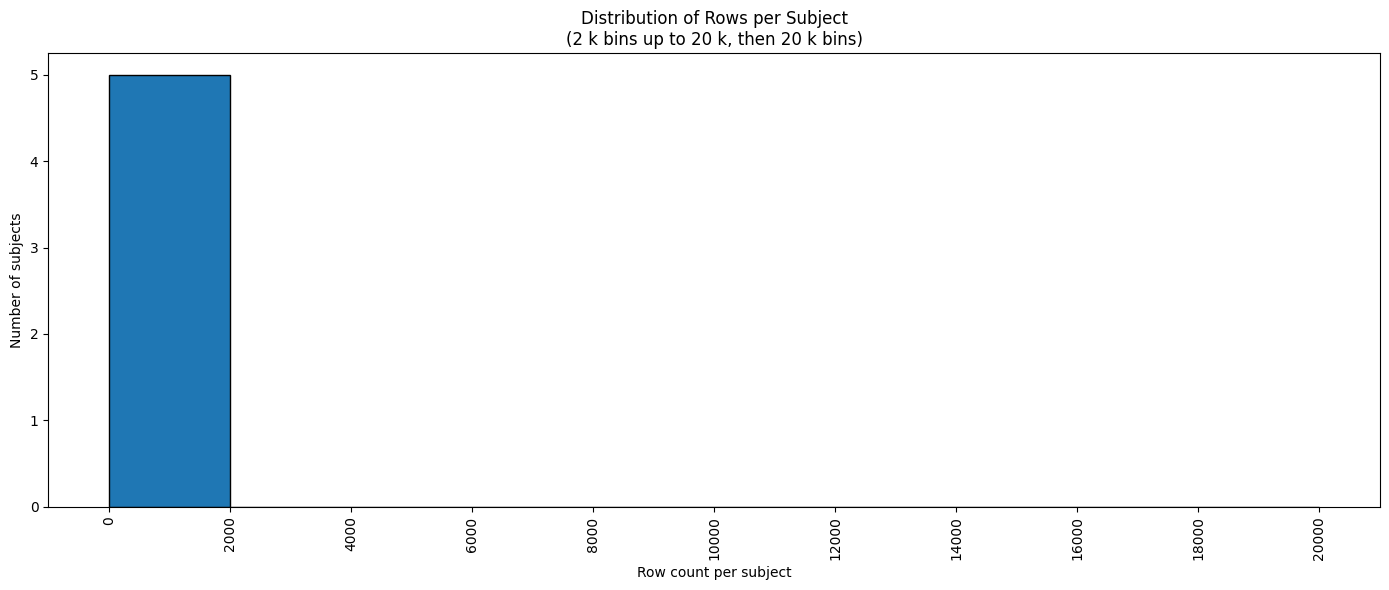

'Subjects: 5 | Total rows: 6174 | Mean rows/subject: 1234.80 | Std: 698.27 | Min: 1 | Max: 1706'

In [5]:
# Re-run: build per-subject counts and show only the plots + a concise textual summary.
# If `df` doesn't exist yet, a small demo DataFrame is created.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    df  # check if df exists
    using_demo = False
except NameError:
    using_demo = True

if using_demo:
    np.random.seed(0)
    demo_subjects = [f"S{i:02d}" for i in range(1, 9)]
    demo_rows = []
    for s in demo_subjects:
        n = np.random.randint(5, 35)
        for j in range(n):
            demo_rows.append({"segment_id": f"{s}_{j:04d}", "feature_a": np.random.randn()})
    df = pd.DataFrame(demo_rows)

# Extract subject_id
if "segment_id" not in df.columns:
    raise ValueError("Your DataFrame must contain a 'segment_id' column like 'subject_segment'.")

df = df.copy()
df["subject_id"] = df["segment_id"].astype(str).str.split("_", n=1).str[0]

# Per-subject counts
counts = df.groupby("subject_id")["segment_id"].count().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(12,6))
counts.plot(kind="bar")
plt.title("Rows per Subject")
plt.xlabel("Subject ID")
plt.ylabel("Row count")
plt.tight_layout()
plt.show()


plt.figure(figsize=(14,6))

# fine bins 0–20 k every 2 k
fine_part  = np.arange(0, 20001, 2000)
# coarse bins 20 k–max every 20 k
coarse_part = np.arange(20000, counts.max() + 20001, 20000)

# combine bins and drop duplicate 20 k
bins = np.unique(np.concatenate([fine_part, coarse_part]))

counts.plot(kind="hist", bins=bins, edgecolor="black")

plt.title("Distribution of Rows per Subject\n(2 k bins up to 20 k, then 20 k bins)")
plt.xlabel("Row count per subject")
plt.ylabel("Number of subjects")

# force tick marks: 0–20 k every 2 k, then every 20 k afterwards
xticks_fine   = np.arange(0, 20001, 2000)
xticks_coarse = np.arange(20000, counts.max() + 20001, 20000)
plt.xticks(np.unique(np.concatenate([xticks_fine, xticks_coarse])),
           rotation=90)  # <- rotate tick labels vertically

plt.tight_layout()
plt.show()



# Brief stats for the user
summary_text = (
    f"Subjects: {int(counts.size)} | "
    f"Total rows: {int(counts.sum())} | "
    f"Mean rows/subject: {counts.mean():.2f} | "
    f"Std: {counts.std(ddof=1):.2f} | "
    f"Min: {int(counts.min())} | "
    f"Max: {int(counts.max())}"
)
summary_text


------------------------

### after the distribution analyzes of the data to work on 

> as you see the correlation cannot processed because the imbalance on the dataframes ; hence we are going to format overall system to take inside the spesific amount of the data to learn the data on the variation/ based on th at we are going to make trimming based on the up and down limits to provide the interval to work on how the managed on that way 


In [6]:
import pandas as pd
import numpy as np

def trim_by_subject_counts(
    df: pd.DataFrame,
    id_col: str = "segment_id",
    subject_col: str | None = None,
    min_rows_per_subject: int = 1000,
    max_rows_per_subject: int = 2000,
    random_state: int | None = 42,
) -> pd.DataFrame:
    """
    Trim an overall dataset by per-subject row counts.

    Rules:
      1) Subjects with < min_rows_per_subject are removed entirely.
      2) Subjects with >= min_rows_per_subject are kept, but if they have
         > max_rows_per_subject, they are downsampled to max_rows_per_subject
         (without replacement, reproducible via random_state).

    Parameters
    ----------
    df : DataFrame
        Input dataframe. Must have either:
          - `subject_col` giving subject IDs directly, OR
          - `id_col` like "S01_0001" so subject is the part before the first "_".
    id_col : str
        Column containing IDs of the form "subject_something". Used if `subject_col` is None.
    subject_col : str | None
        Column name containing subject IDs. If None, subject is parsed from `id_col` before the first "_".
    min_rows_per_subject : int
        Minimum support. Subjects with fewer rows are dropped completely.
    max_rows_per_subject : int
        Cap. Subjects with more rows are downsampled to this count.
    random_state : int | None
        Seed for reproducible sampling. Use None for non-deterministic.

    Returns
    -------
    DataFrame
        Trimmed dataframe following the rules above. Original column order preserved.
    """
    if subject_col is None:
        if id_col not in df.columns:
            raise ValueError(f"'{id_col}' not found. Provide a valid `id_col` or set `subject_col`.")
        # Work on a copy to avoid mutating caller's df
        tmp = df.copy()
        tmp["_subject_id_tmp"] = (
            tmp[id_col].astype(str).str.split("_", n=1).str[0]
        )
        subj_col = "_subject_id_tmp"
        drop_tmp = True
    else:
        if subject_col not in df.columns:
            raise ValueError(f"'{subject_col}' not found in DataFrame.")
        tmp = df.copy()
        subj_col = subject_col
        drop_tmp = False

    # Compute sizes
    sizes = tmp.groupby(subj_col, sort=False).size()

    # Keep subjects meeting minimum support
    eligible_subjects = sizes[sizes >= min_rows_per_subject].index

    if len(eligible_subjects) == 0:
        # Return empty df with same columns if nothing qualifies
        result = tmp.iloc[0:0].copy()
        if drop_tmp:
            result = result.drop(columns=[subj_col])
        return result

    rng = np.random.default_rng(random_state)
    out_frames = []

    for s in eligible_subjects:
        g = tmp.loc[tmp[subj_col] == s]
        n = len(g)
        if n > max_rows_per_subject:
            # sample without replacement
            idx = rng.choice(g.index.to_numpy(), size=max_rows_per_subject, replace=False)
            g = g.loc[idx]
        # else keep as-is (you could shuffle if desired)
        out_frames.append(g)

    out = pd.concat(out_frames, axis=0)

    # Optional cleanup if we created a temporary subject column
    if drop_tmp:
        out = out.drop(columns=[subj_col])

    # Preserve original column order
    out = out[df.columns]

    # (Optional) reset index for cleanliness
    out = out.reset_index(drop=True)
    return out


In [7]:
new_df = trim_by_subject_counts(df, id_col="segment_id",
                                min_rows_per_subject=1000,
                                max_rows_per_subject=1001,
                                random_state=42)
print(new_df.shape, new_df.head())


(4004, 7)                                         ppg_norm_120  \
0  [0.9833023548126221, 0.9640799164772034, 0.923...   
1  [0.9299554228782654, 0.9172319173812866, 0.891...   
2  [0.903026282787323, 0.896172046661377, 0.86724...   
3  [1.0, 0.9908432364463806, 0.966729998588562, 0...   
4  [1.0, 0.9897334575653076, 0.960800290107727, 0...   

                                         ppg_raw_120        sbp       dbp  \
0  [0.14282391965389252, 0.1389513909816742, 0.13...   92.96875  43.75000   
1  [0.19388198852539062, 0.18969638645648956, 0.1...  103.90625  52.34375   
2  [0.19874584674835205, 0.19649477303028107, 0.1...  100.78125  46.87500   
3  [0.1417662799358368, 0.1396927684545517, 0.134...   96.87500  46.87500   
4  [0.18773771822452545, 0.18485765159130096, 0.1...   98.43750  44.53125   

     segment_id                                            abp_raw subject_id  
0  3207225_0005  [57.8125, 58.59375, 59.375, 60.15625, 60.9375,...    3207225  
1  3207225_0005  [68.75, 69.53

In [8]:
### release the memory of the df (too unncesseary big formation to work on . . . )

import gc

del df          # remove the reference to the DataFrame
gc.collect()    # force the garbage collector to free memory now

3856

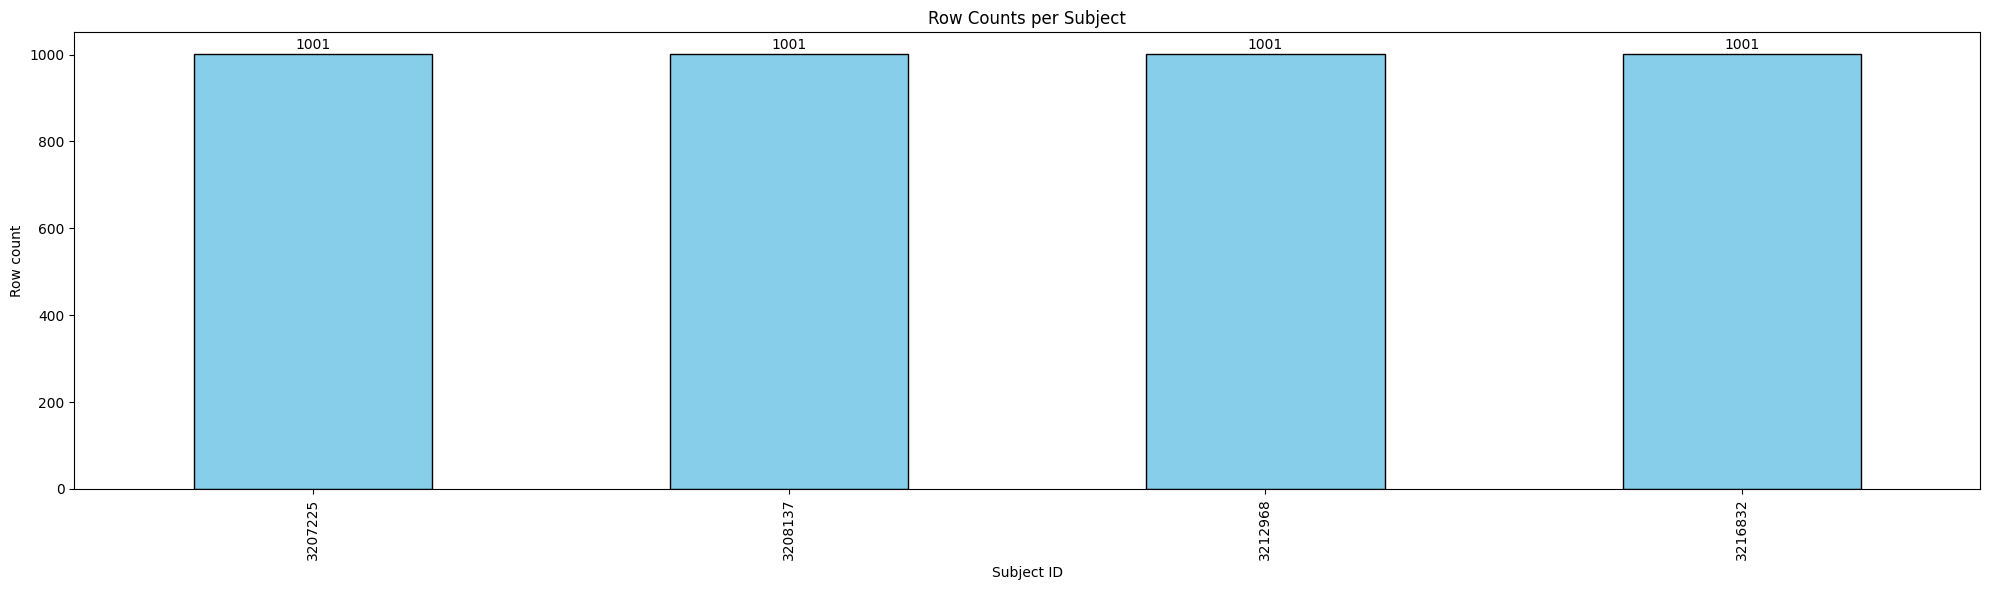

Subjects retained: 4 | Total rows: 4004 | Mean rows/subject: 1001.00 | Std: 0.00 | Min: 1001 | Max: 1001


'\n\nThis is end of the how we can processed the dataframe to process for the model training per the subject and their window confeguration ;\nafter that point, we will follow the much more standard apparoahces for providing the enough model performance to show the estimation on SBP and DBP.\n\n    -> in default settings we will use the already prepared one (./data/proprocessing_ready_set/df_137_sampled_peak_by_peak_rows_fixed_1000.pkl) which was included 137 sample; selection of the yours can be changable on the below \n\n'

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_counts_with_summary(df, id_col="segment_id"):
    # Extract subject IDs
    subjects = df[id_col].astype(str).str.split("_", n=1).str[0]
    counts = subjects.value_counts().sort_index()

    # Plot bar chart
    plt.figure(figsize=(20, 6))
    counts.plot(kind="bar", color="skyblue", edgecolor="black")

    # Labels
    plt.title("Row Counts per Subject")
    plt.xlabel("Subject ID")
    plt.ylabel("Row count")

    # Add value labels on top of bars
    for idx, value in enumerate(counts):
        plt.text(idx, value + 5, str(value), ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    # Summary
    summary = (
        f"Subjects retained: {counts.size} | "
        f"Total rows: {counts.sum()} | "
        f"Mean rows/subject: {counts.mean():.2f} | "
        f"Std: {counts.std(ddof=1):.2f} | "
        f"Min: {counts.min()} | "
        f"Max: {counts.max()}"
    )
    print(summary)
    return summary

# Example usage
summary = plot_subject_counts_with_summary(new_df)



"""

This is end of the how we can processed the dataframe to process for the model training per the subject and their window confeguration ;
after that point, we will follow the much more standard apparoahces for providing the enough model performance to show the estimation on SBP and DBP.

    -> in default settings we will use the already prepared one (./data/preprocessing_ready_set/df_137_sampled_peak_by_peak_rows_fixed_1000.pkl) which was included 137 sample; selection of the yours can be changable on the below 

"""


--------------

### New fixed window dataset usage or already prepared one 
> now we are can select one of them ; 
- one is already prepared and the other one is recently prepared with subjects under the toy_segments considered. you can select one of them and leave out the other as a comment and continue to the model training/evaluation

!!! If you want to use the actual methodology data; please reach the collabrators or the owner of repo :: (/data/preprocessing_ready_set/df_137_sampled_peak_by_peak_rows_fixed_1000.pkl)

In [ ]:
### for futures use 
import pandas as pd
# df = pd.read_pickle('./data/preprocessing_ready_set/df_137_sampled_peak_by_peak_rows_fixed_1000.pkl') # --> we can directly consider this (already prepared one )


df = new_df.copy() # --> you can continue with this one as well (recently prepared one )


In [11]:
df.head()

ppg_norm_120  \
0  [0.9833023548126221, 0.9640799164772034, 0.923...   
1  [0.9299554228782654, 0.9172319173812866, 0.891...   
2  [0.903026282787323, 0.896172046661377, 0.86724...   
3  [1.0, 0.9908432364463806, 0.966729998588562, 0...   
4  [1.0, 0.9897334575653076, 0.960800290107727, 0...   

                                         ppg_raw_120        sbp       dbp  \
0  [0.14282391965389252, 0.1389513909816742, 0.13...   92.96875  43.75000   
1  [0.19388198852539062, 0.18969638645648956, 0.1...  103.90625  52.34375   
2  [0.19874584674835205, 0.19649477303028107, 0.1...  100.78125  46.87500   
3  [0.1417662799358368, 0.1396927684545517, 0.134...   96.87500  46.87500   
4  [0.18773771822452545, 0.18485765159130096, 0.1...   98.43750  44.53125   

     segment_id                                            abp_raw subject_id  
0  3207225_0005  [57.8125, 58.59375, 59.375, 60.15625, 60.9375,...    3207225  
1  3207225_0005  [68.75, 69.53125, 69.53125, 70.3125, 69.53125,...    3207225  
2  3207225_0005  [62.5, 63.28125, 64.0625, 64.0625, 64.84375, 6...    3207225  
3  3207225_0005  [67.1875, 67.1875, 67.96875, 67.1875, 67.1875,...    3207225  
4  3207225_0005  [58.59375, 59.375, 60.15625, 60.15625, 60.1562...    3207225

### Imbalance consideration 

> very important point on the models is the balanced dataset application to work on so we forgot this to make and checking overall variations to perform only for the data leakage . . . not directyh the how muhc variance and good dividency on the stage of those so there is the investigate process starts . . . 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple, Optional

def analyze_bp_balance(
    df: pd.DataFrame,
    sbp_col: str = "sbp",
    dbp_col: str = "dbp",
    out_col: str = "bp_category",
    plot: bool = True,
    mutate: bool = True,
    schema: Optional[List[Tuple[str, Callable[[float, float], bool]]]] = None,
) -> Dict[str, Any]:
    """
    Categorize rows by SBP/DBP and assess class balance.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing columns with SBP and DBP values.
    sbp_col, dbp_col : str
        Column names for systolic and diastolic BP.
    out_col : str
        Name of the output category column.
    plot : bool
        If True, show a bar chart of class counts.
    mutate : bool
        If True, writes `out_col` into df. If False, returns a Series instead.
    schema : list[(label, rule(sbp, dbp) -> bool)] or None
        Custom categorization rules. First rule that returns True wins.
        If None, uses the 5-category ACC/AHA-like schema:
            - Hypertensive Crisis: sbp >= 180 or dbp >= 120
            - Hypertension – Stage 2: sbp >= 140 or dbp >= 90
            - Hypertension – Stage 1: sbp >= 130 or dbp >= 80
            - Elevated: sbp in [120,129] and dbp < 80
            - Normal: sbp < 120 and dbp < 80

    Returns
    -------
    result : dict
        {
          "counts": pandas.Series,
          "percents": pandas.Series,
          "imbalance_ratio": float,
          "category_series": pandas.Series  # also written to df[out_col] if mutate=True
        }

    Notes
    -----
    - Imbalance Ratio (IR) = max_count / min_count among nonzero classes.
    - To create more bins (e.g., split Stage 2, add 'Isolated Systolic', etc.),
      pass a custom `schema` ordered from most severe/rare to least.
    """

    # Default 5-category schema (ordered by severity to avoid mislabeling)
    if schema is None:
        schema = [
            ("Hypertensive Crisis", lambda s, d: (s is not None and s >= 180) or (d is not None and d >= 120)),
            ("Hypertension – Stage 2", lambda s, d: (s is not None and s >= 140) or (d is not None and d >= 90)),
            ("Hypertension – Stage 1", lambda s, d: (s is not None and s >= 130) or (d is not None and d >= 80)),
            ("Elevated",              lambda s, d: (s is not None and 120 <= s <= 129) and (d is not None and d < 80)),
            ("Normal",                lambda s, d: (s is not None and s < 120) and (d is not None and d < 80)),
        ]

    # Vectorized application
    sbp_vals = df[sbp_col].to_numpy()
    dbp_vals = df[dbp_col].to_numpy()

    labels = np.empty(len(df), dtype=object)
    labels[:] = None

    # Apply rules in order; first match wins
    unmatched = np.ones(len(df), dtype=bool)
    for label, rule in schema:
        mask = np.fromiter((rule(s, d) for s, d in zip(sbp_vals, dbp_vals)), dtype=bool, count=len(df))
        mask = mask & unmatched
        labels[mask] = label
        unmatched &= ~mask

    # Anything still unmatched -> "Uncategorized" (e.g., NaNs or conflicting rules)
    if unmatched.any():
        labels[unmatched] = "Uncategorized"

    cat_series = pd.Series(labels, index=df.index, name=out_col)

    if mutate:
        df[out_col] = cat_series

    # Balance stats
    counts = cat_series.value_counts(dropna=False)
    percents = cat_series.value_counts(normalize=True, dropna=False) * 100

    # IR over classes that actually occurred (exclude zero by construction)
    nonzero = counts[counts > 0]
    IR = float(nonzero.max() / nonzero.min()) if len(nonzero) > 1 else 1.0

    # Plot (optional)
    if plot:
        # Ensure consistent order: schema order + Uncategorized if present
        ordered_labels = [lbl for lbl, _ in schema]
        if "Uncategorized" in counts.index and "Uncategorized" not in ordered_labels:
            ordered_labels.append("Uncategorized")
        counts.reindex(ordered_labels).plot(kind="bar")
        plt.title("Blood Pressure Category Distribution")
        plt.ylabel("Count")
        plt.xlabel("BP Category")
        plt.tight_layout()
        plt.show()

    return {
        "counts": counts,
        "percents": percents,
        "imbalance_ratio": IR,
        "category_series": cat_series,
    }


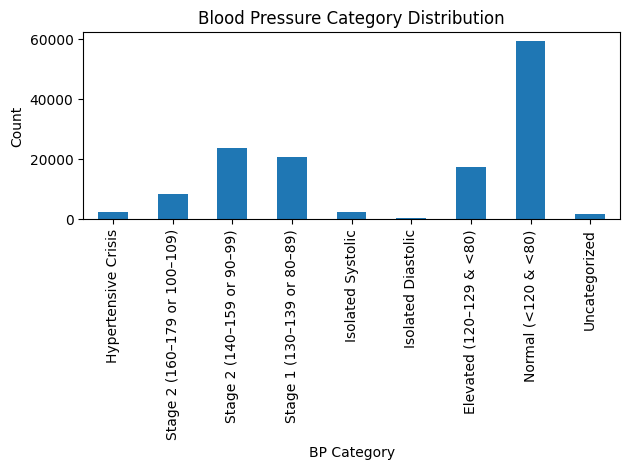

In [6]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)


-------------

#### new dataframe architecture formation to include the model 
- fixed 120 sample window
- two output layer for the formation 

In [7]:
# Create merged column
df["bp_pair"] = df.apply(lambda row: [row["sbp"], row["dbp"]], axis=1)

In [8]:
# Drop specific columns
# df = df.drop(columns=["dbp", "sbp"])

In [9]:
df_bp_paired = df.copy()


# Rename columns
df_bp_paired = df_bp_paired.rename(columns={
    "ppg_norm_120": "norm_ppg",
    "ppg_raw_120": "raw_ppg",
})

"""
Now the dataframe df_bp_paired contains the blood pressure pairs in a single column. and we are going to use that for the modle trainign and the other preprocessing applications ; 

"""

'\nNow the dataframe df_bp_paired contains the blood pressure pairs in a single column. and we are going to use that for the modle trainign and the other preprocessing applications ; \n\n'

### data splitting



the randomly considered ID splitting

In [10]:
from typing import Optional, Tuple, Dict
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def split_subjectwise_dataframe_safe(
    df: pd.DataFrame,
    test_size: float = 0.2,
    val_size: float = 0.1,
    random_state: int = 42,
    n_subjects: Optional[int] = None,          # <- NEW: randomly choose this many subjects from unique_subjects
    chosen_subjects: Optional[list] = None     # <- NEW: or pass an explicit subject list to use
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Subject-wise split into train/val/test without leakage. Optionally first choose a random
    subset of subjects to include in the experiment.

    Parameters:
        df (pd.DataFrame): Must contain a 'segment_id' column in 'subject_segment' format.
        test_size (float): Fraction of subjects for the test split (by subjects, not rows).
        val_size  (float): Fraction of subjects for the validation split (by subjects, not rows).
        random_state (int): Random seed for reproducibility of subject selection and splits.
        n_subjects (int|None): If set, randomly sample exactly this many subjects from unique_subjects, then split.
        chosen_subjects (list|None): If provided, use exactly these subjects (overrides n_subjects).

    Returns:
        df_train, df_val, df_test, summary_df
          - df_*: DataFrames with the original columns (no 'subject_id' leakage column)
          - summary_df: a tidy report with per-split subject/sample counts and variance diagnostics
    """
    if "segment_id" not in df.columns:
        raise ValueError("df must contain a 'segment_id' column like 'subject_segment'")

    df = df.copy()
    df["subject_id"] = df["segment_id"].apply(lambda x: str(x).split("_")[0])
    unique_subjects = np.array(pd.unique(df["subject_id"]))

    # --- Choose which subjects to use (randomly or by explicit list) ---
    rng = np.random.RandomState(random_state)

    if chosen_subjects is not None:
        used_subjects = np.array(chosen_subjects)
        missing = set(used_subjects) - set(unique_subjects)
        if missing:
            raise ValueError(f"chosen_subjects contains subjects not in df: {sorted(missing)}")
    elif n_subjects is not None:
        if n_subjects < 1:
            raise ValueError("n_subjects must be >= 1")
        if n_subjects > len(unique_subjects):
            raise ValueError(f"n_subjects={n_subjects} exceeds the number of unique subjects ({len(unique_subjects)}).")
        used_subjects = rng.choice(unique_subjects, size=n_subjects, replace=False)
    else:
        used_subjects = unique_subjects

    if len(used_subjects) < 3:
        print(f"⚠️ Not enough subjects to split. Found only {len(used_subjects)} subject(s). Returning all as training set.")
        out = df[df["subject_id"].isin(used_subjects)].drop(columns=["subject_id"]).reset_index(drop=True)
        # Minimal summary
        summary_df = pd.DataFrame({
            "split": ["train"], 
            "n_subjects": [len(used_subjects)], 
            "n_samples": [len(out)],
            "per_subject_mean": [len(out) / max(len(used_subjects), 1)],
            "per_subject_var": [np.nan]
        })
        return out, pd.DataFrame(), pd.DataFrame(), summary_df

    # --- Restrict DF to chosen/used subjects only ---
    df = df[df["subject_id"].isin(used_subjects)].reset_index(drop=True)

    # --- Subject-wise splits (by subjects, not rows) ---
    subjects_train_val, subjects_test = train_test_split(
        used_subjects, test_size=test_size, random_state=random_state, shuffle=True
    )
    subjects_train, subjects_val = train_test_split(
        subjects_train_val,
        test_size=val_size / (1 - test_size),
        random_state=random_state,
        shuffle=True
    )

    # --- Build splits ---
    df_train = df[df["subject_id"].isin(subjects_train)].reset_index(drop=True)
    df_val   = df[df["subject_id"].isin(subjects_val)].reset_index(drop=True)
    df_test  = df[df["subject_id"].isin(subjects_test)].reset_index(drop=True)

    # --- Safety: ensure no subject leakage ---
    set_train = set(df_train["subject_id"].unique())
    set_val   = set(df_val["subject_id"].unique())
    set_test  = set(df_test["subject_id"].unique())
    assert set_train.isdisjoint(set_val) and set_train.isdisjoint(set_test) and set_val.isdisjoint(set_test), \
        "Subject leakage detected across splits."

    # --- Diagnostics: per-split subject/sample stats and variance of samples-per-subject ---
    def per_split_stats(part_df, split_name):
        counts = part_df.groupby("subject_id")["segment_id"].count()
        return {
            "split": split_name,
            "n_subjects": counts.size,
            "n_samples": int(counts.sum()),
            "per_subject_mean": float(counts.mean()) if counts.size else np.nan,
            "per_subject_var": float(counts.var(ddof=1)) if counts.size > 1 else np.nan
        }

    summary_rows = [
        per_split_stats(df_train, "train"),
        per_split_stats(df_val,   "val"),
        per_split_stats(df_test,  "test"),
    ]
    summary_df = pd.DataFrame(summary_rows, columns=["split","n_subjects","n_samples","per_subject_mean","per_subject_var"])

    # Drop helper column before returning data
    return (
        df_train.drop(columns=["subject_id"]),
        df_val.drop(columns=["subject_id"]),
        df_test.drop(columns=["subject_id"]),
        summary_df
    )




In [11]:

# Example usage:
df_train_safe, df_val_safe, df_test_safe, split_summary = split_subjectwise_dataframe_safe(
    df_bp_paired,
    test_size=0.2,
    val_size=0.1,
    random_state=42,
)
print(split_summary)

   split  n_subjects  n_samples  per_subject_mean  per_subject_var
0  train          95      95095            1001.0              0.0
1    val          14      14014            1001.0              0.0
2   test          28      28028            1001.0              0.0


In [12]:
df_test_safe

norm_ppg  \
0      [1.0, 0.9923401474952698, 0.9717060923576355, ...   
1      [1.0, 0.9924919605255127, 0.9682204127311707, ...   
2      [0.9577745199203491, 0.9443651437759399, 0.915...   
3      [1.0, 0.9936443567276001, 0.9723814725875854, ...   
4      [0.9564376473426819, 0.9443494081497192, 0.920...   
...                                                  ...   
28023  [1.0, 0.9949896335601807, 0.9745521545410156, ...   
28024  [0.9230728149414062, 0.911346435546875, 0.8850...   
28025  [1.0, 0.9909089803695679, 0.9695823192596436, ...   
28026  [0.8705289959907532, 0.8592585921287537, 0.834...   
28027  [1.0, 0.9843520522117615, 0.9423285722732544, ...   

                                                 raw_ppg         sbp  \
0      [0.5624096393585205, 0.555824339389801, 0.5380...  125.871254   
1      [0.40117669105529785, 0.39644119143486023, 0.3...  129.290344   
2      [0.5236141681671143, 0.5106876492500305, 0.483...  118.495796   
3      [0.13719548285007477, 0.13557091355323792, 0.1...  123.673271   
4      [0.5178124904632568, 0.5063748955726624, 0.484...  124.405937   
...                                                  ...         ...   
28023  [0.9463739395141602, 0.9387648701667786, 0.907...  111.754982   
28024  [0.9330135583877563, 0.9151555895805359, 0.875...  121.250252   
28025  [1.2132242918014526, 1.1956729888916016, 1.154...  102.376945   
28026  [0.7815637588500977, 0.7645214796066284, 0.727...  128.479156   
28027  [1.1148277521133423, 1.0888402462005615, 1.019...  117.225510   

             dbp    segment_id  \
0      69.993599  3101354_0002   
1      78.883232  3101354_0002   
2      70.970482  3101354_0002   
3      77.124840  3101354_0002   
4      75.757202  3101354_0002   
...          ...           ...   
28023  58.729980  3211235_0001   
28024  64.356804  3211235_0001   
28025  49.234715  3211235_0001   
28026  65.489983  3211235_0001   
28027  61.738766  3211235_0001   

                                                 abp_raw  \
0      [74.2430419921875, 73.5103759765625, 72.973091...   
1      [79.61589050292969, 79.61589050292969, 79.6158...   
2      [73.90113067626953, 73.55921936035156, 73.1684...   
3      [79.0297622680664, 79.12744903564453, 79.42051...   
4      [78.24825286865234, 77.85750579833984, 77.4667...   
...                                                  ...   
28023  [67.60004425048828, 67.05298614501953, 66.5059...   
28024  [74.00836944580078, 73.38316345214844, 72.7579...   
28025  [56.033790588378906, 55.48674011230469, 54.939...   
28026  [75.2978515625, 74.75080108642578, 74.32096862...   
28027  [70.92143249511719, 70.37438201904297, 69.7882...   

                  bp_category_8                                   bp_pair  
0      Elevated (120–129 & <80)   [125.87125396728516, 69.99359893798828]  
1                 Uncategorized   [129.29034423828125, 78.88323211669922]  
2           Normal (<120 & <80)    [118.49579620361328, 70.9704818725586]  
3      Elevated (120–129 & <80)   [123.67327117919922, 77.12483978271484]  
4      Elevated (120–129 & <80)    [124.40593719482422, 75.7572021484375]  
...                         ...                                       ...  
28023       Normal (<120 & <80)       [111.7549819946289, 58.72998046875]  
28024  Elevated (120–129 & <80)   [121.25025177001953, 64.35680389404297]  
28025       Normal (<120 & <80)   [102.37694549560547, 49.23471450805664]  
28026  Elevated (120–129 & <80)   [128.47915649414062, 65.48998260498047]  
28027       Normal (<120 & <80)  [117.22550964355469, 61.738765716552734]  

[28028 rows x 8 columns]

#### Cross check on those 

segment & subject id & window check 

In [14]:
def check_subject_leakage(df_train, df_val, df_test):
    """
    Checks for subject leakage across train, validation, and test sets.

    Parameters:
        df_train, df_val, df_test: DataFrames with 'segment_id' column in format 'subject_segment'

    Returns:
        dict with subject sets and intersection checks
    """
    def extract_subjects(df):
        if df.empty:
            return set()
        return set(df['segment_id'].apply(lambda x: x.split("_")[0]))

    subjects_train = extract_subjects(df_train)
    subjects_val = extract_subjects(df_val)
    subjects_test = extract_subjects(df_test)

    print(len(subjects_train), len(subjects_val), len(subjects_test))
    
    return {
        "subjects_in_train": subjects_train,
        "subjects_in_val": subjects_val,
        "subjects_in_test": subjects_test,
        "train ∩ val": subjects_train & subjects_val,
        "train ∩ test": subjects_train & subjects_test,
        "val ∩ test": subjects_val & subjects_test
    }

# Run the check
subject_leakage_check = check_subject_leakage(df_train_safe, df_val_safe, df_test_safe)

# Format for display
leakage_df = pd.DataFrame({
    "Train ∩ Val": [subject_leakage_check["train ∩ val"]],
    "Train ∩ Test": [subject_leakage_check["train ∩ test"]],
    "Val ∩ Test": [subject_leakage_check["val ∩ test"]],
    "Train Subjects": [subject_leakage_check["subjects_in_train"]],
    "Val Subjects": [subject_leakage_check["subjects_in_val"]],
    "Test Subjects": [subject_leakage_check["subjects_in_test"]],
})

leakage_df


95 14 28


Train ∩ Val Train ∩ Test Val ∩ Test  \
0          {}           {}         {}   

                                      Train Subjects  \
0  {3000397, 3208668, 3210318, 3102350, 3104446, ...   

                                        Val Subjects  \
0  {3002921, 3106152, 3205889, 3101960, 3200359, ...   

                                       Test Subjects  
0  {3206481, 3203264, 3207227, 3108389, 3101354, ...

In [15]:
df_train_safe

norm_ppg  \
0      [1.0, 0.9915311336517334, 0.9729101657867432, ...   
1      [1.0, 0.995421826839447, 0.9806426167488098, 0...   
2      [1.0, 0.9890457391738892, 0.9673372507095337, ...   
3      [1.0, 0.980114221572876, 0.9405338764190674, 0...   
4      [1.0, 0.9955838918685913, 0.9768851399421692, ...   
...                                                  ...   
95090  [1.0, 0.9699950814247131, 0.9072200059890747, ...   
95091  [1.0, 0.9855754375457764, 0.9402979016304016, ...   
95092  [1.0, 0.9804902076721191, 0.9251721501350403, ...   
95093  [1.0, 0.9815031886100769, 0.9299962520599365, ...   
95094  [1.0, 0.9853812456130981, 0.94166499376297, 0....   

                                                 raw_ppg         sbp  \
0      [0.22330717742443085, 0.21965570747852325, 0.2...   72.760605   
1      [0.1999799609184265, 0.19814741611480713, 0.19...   76.771034   
2      [0.22358739376068115, 0.21896034479141235, 0.2...   89.375237   
3      [0.24740473926067352, 0.24058467149734497, 0.2...   85.937721   
4      [0.20677496492862701, 0.20513752102851868, 0.1...  107.708611   
...                                                  ...         ...   
95090  [0.08824805915355682, 0.08405523002147675, 0.0...  147.500000   
95091  [0.11093223839998245, 0.10840965062379837, 0.1...  138.750000   
95092  [0.11485637724399567, 0.11157599836587906, 0.1...  143.750000   
95093  [0.08836733549833298, 0.08590935915708542, 0.0...  147.500000   
95094  [0.10400267690420151, 0.10133536159992218, 0.0...  122.500000   

             dbp    segment_id  \
0      49.843880  3100237_0002   
1      44.114697  3100237_0002   
2      48.698044  3100237_0002   
3      58.437653  3100237_0002   
4      71.614769  3100237_0002   
...          ...           ...   
95090  66.250000  3211632_0002   
95091  65.625000  3211632_0002   
95092  69.375000  3211632_0002   
95093  67.500000  3211632_0002   
95094  76.250000  3211632_0002   

                                                 abp_raw  \
0      [53.854305267333984, 53.854305267333984, 53.28...   
1      [48.125125885009766, 47.552207946777344, 47.55...   
2      [52.70846939086914, 52.13555145263672, 51.5626...   
3      [72.76060485839844, 72.18769073486328, 71.0418...   
4      [73.90644073486328, 74.47936248779297, 75.0522...   
...                                                  ...   
95090  [81.25, 80.0, 78.75, 76.875, 75.0, 73.75, 73.1...   
95091  [83.75, 83.125, 82.5, 81.25, 80.0, 78.125, 76....   
95092  [87.5, 86.25, 85.0, 83.75, 82.5, 81.25, 79.375...   
95093  [87.5, 86.25, 84.375, 83.125, 81.25, 79.375, 7...   
95094  [89.375, 89.375, 89.375, 89.375, 89.375, 88.75...   

                    bp_category_8                                 bp_pair  
0             Normal (<120 & <80)  [72.76060485839844, 49.84387969970703]  
1             Normal (<120 & <80)  [76.77103424072266, 44.11469650268555]  
2             Normal (<120 & <80)  [89.37523651123047, 48.69804382324219]  
3             Normal (<120 & <80)  [85.9377212524414, 58.437652587890625]  
4             Normal (<120 & <80)  [107.70861053466797, 71.6147689819336]  
...                           ...                                     ...  
95090  Stage 2 (140–159 or 90–99)                          [147.5, 66.25]  
95091  Stage 1 (130–139 or 80–89)                        [138.75, 65.625]  
95092  Stage 2 (140–159 or 90–99)                        [143.75, 69.375]  
95093  Stage 2 (140–159 or 90–99)                           [147.5, 67.5]  
95094    Elevated (120–129 & <80)                          [122.5, 76.25]  

[95095 rows x 8 columns]

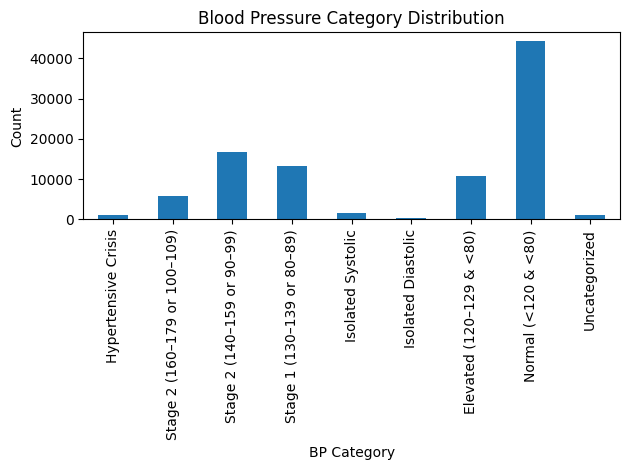

{'counts': bp_category_8
 Normal (<120 & <80)             44287
 Stage 2 (140–159 or 90–99)      16773
 Stage 1 (130–139 or 80–89)      13316
 Elevated (120–129 & <80)        10872
 Stage 2 (160–179 or 100–109)     5750
 Isolated Systolic                1571
 Uncategorized                    1180
 Hypertensive Crisis              1038
 Isolated Diastolic                308
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             46.571323
 Stage 2 (140–159 or 90–99)      17.638151
 Stage 1 (130–139 or 80–89)      14.002839
 Elevated (120–129 & <80)        11.432778
 Stage 2 (160–179 or 100–109)     6.046585
 Isolated Systolic                1.652032
 Uncategorized                    1.240864
 Hypertensive Crisis              1.091540
 Isolated Diastolic               0.323887
 Name: proportion, dtype: float64,
 'imbalance_ratio': 143.78896103896105,
 'category_series': 0               Normal (<120 & <80)
 1               Normal (<120 & <80)
 2            

In [16]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_train_safe, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

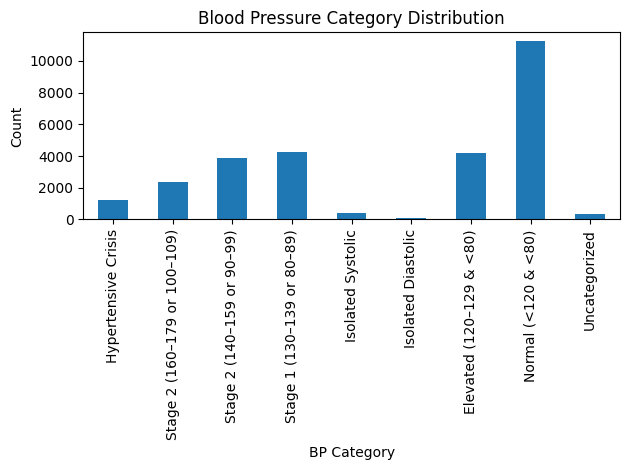

{'counts': bp_category_8
 Normal (<120 & <80)             11238
 Stage 1 (130–139 or 80–89)       4239
 Elevated (120–129 & <80)         4183
 Stage 2 (140–159 or 90–99)       3865
 Stage 2 (160–179 or 100–109)     2368
 Hypertensive Crisis              1250
 Isolated Systolic                 420
 Uncategorized                     365
 Isolated Diastolic                100
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             40.095619
 Stage 1 (130–139 or 80–89)      15.124162
 Elevated (120–129 & <80)        14.924361
 Stage 2 (140–159 or 90–99)      13.789782
 Stage 2 (160–179 or 100–109)     8.448694
 Hypertensive Crisis              4.459826
 Isolated Systolic                1.498501
 Uncategorized                    1.302269
 Isolated Diastolic               0.356786
 Name: proportion, dtype: float64,
 'imbalance_ratio': 112.38,
 'category_series': 0        Elevated (120–129 & <80)
 1                   Uncategorized
 2             Normal (<120 & 

In [17]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_test_safe, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

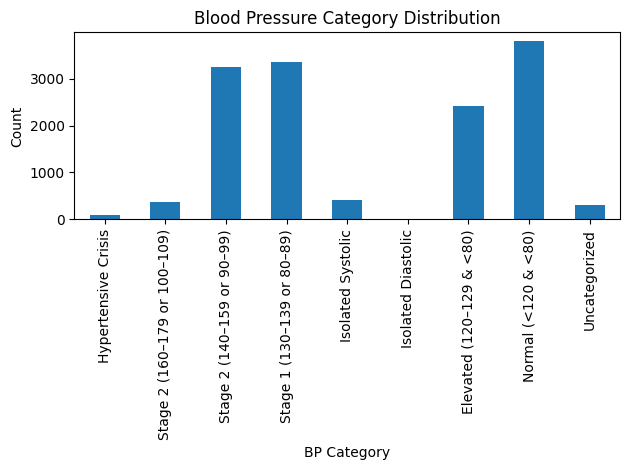

{'counts': bp_category_8
 Normal (<120 & <80)             3794
 Stage 1 (130–139 or 80–89)      3354
 Stage 2 (140–159 or 90–99)      3239
 Elevated (120–129 & <80)        2419
 Isolated Systolic                407
 Stage 2 (160–179 or 100–109)     380
 Uncategorized                    312
 Hypertensive Crisis               98
 Isolated Diastolic                11
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             27.072927
 Stage 1 (130–139 or 80–89)      23.933210
 Stage 2 (140–159 or 90–99)      23.112602
 Elevated (120–129 & <80)        17.261310
 Isolated Systolic                2.904239
 Stage 2 (160–179 or 100–109)     2.711574
 Uncategorized                    2.226345
 Hypertensive Crisis              0.699301
 Isolated Diastolic               0.078493
 Name: proportion, dtype: float64,
 'imbalance_ratio': 344.90909090909093,
 'category_series': 0          Elevated (120–129 & <80)
 1        Stage 1 (130–139 or 80–89)
 2        Stage 1 (130–

In [18]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_val_safe, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

----------------------

### time of the trimming via the values which derived from the mean of the validation and train 

In [19]:
import pandas as pd
import numpy as np

def category_proportions(df: pd.DataFrame, cat_col: str) -> pd.Series:
    """Return category proportions as a Series (%) summing to 1.0."""
    s = df[cat_col].value_counts(normalize=True)
    # ensure stable ordering
    return s.sort_index()

def mean_target_from_train_val(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    cat_col: str
) -> pd.Series:
    """
    Compute the target proportions as the mean of train & val proportions.
    Missing categories in either split are treated as 0 and filled.
    """
    p_train = category_proportions(train_df, cat_col)
    p_val   = category_proportions(val_df, cat_col)
    cats = sorted(set(p_train.index).union(set(p_val.index)))
    p_train = p_train.reindex(cats, fill_value=0.0)
    p_val   = p_val.reindex(cats, fill_value=0.0)
    target = (p_train + p_val) / 2.0
    # re-normalize in case rounding/zeros drift
    target = target / target.sum()
    return target

def trim_to_target_proportions(
    df: pd.DataFrame,
    cat_col: str,
    target_props: pd.Series,
    random_state: int = 42,
    strict: bool = False,
) -> pd.DataFrame:
    """
    Downsample df so its category distribution approximates target_props.
    We ONLY REMOVE rows (no upsampling), so rare categories are left intact.
    
    Parameters
    ----------
    df : DataFrame to trim (e.g., your test set)
    cat_col : name of the category column (e.g., 'bp_category_8')
    target_props : Series of target proportions (sum≈1). Index = category labels.
                   You can get this from mean_target_from_train_val(...).
    random_state : sampling seed.
    strict : if True, remove rows even from categories that are underrepresented
             to keep the final proportions as close as possible while
             keeping the **same total size** as the input. If False (default),
             we only trim the *overrepresented* categories and allow the total
             number of rows to decrease.

    Returns
    -------
    trimmed_df : DataFrame with rows sampled to match target as closely as possible.
    """
    rng = np.random.default_rng(random_state)

    # align cats
    current_counts = df[cat_col].value_counts()
    cats = sorted(set(current_counts.index).union(set(target_props.index)))
    current_counts = current_counts.reindex(cats, fill_value=0)
    target_props = target_props.reindex(cats, fill_value=0.0)
    target_props = target_props / max(target_props.sum(), 1e-12)

    n = len(df)

    if strict:
        # keep same total size: assign target counts = round(p * n), but we
        # cannot add to underrepresented categories, so we clip at current_counts
        desired = (target_props * n).round().astype(int)
        keep = desired.clip(upper=current_counts)
        # adjust totals if we lost rows due to clipping
        deficit = int(n - keep.sum())
        if deficit > 0:
            # distribute remaining quota to categories where we haven't hit current_counts yet,
            # prioritizing those with largest (current - keep)
            room = (current_counts - keep)
            order = room.sort_values(ascending=False)
            for c in order.index:
                if deficit == 0: break
                add = min(deficit, int(room[c]))
                keep[c] += add
                deficit -= add
        # if still off (e.g., all cats saturated), final size will be < n
    else:
        # only remove from overrepresented categories:
        # compute target counts at *current* total n, then clip to current_counts
        desired = (target_props * n).round().astype(int)
        keep = desired.clip(upper=current_counts)
        # also keep all rows from categories that are under target
        under = current_counts[current_counts < desired]
        keep.loc[under.index] = current_counts.loc[under.index]

    # sample per category
    parts = []
    for c, k in keep.items():
        if k <= 0 or c not in current_counts.index or current_counts[c] == 0:
            continue
        idx = df.index[df[cat_col] == c].to_numpy()
        # sample without replacement (if k == len(idx), preserves all)
        if k < len(idx):
            chosen = rng.choice(idx, size=int(k), replace=False)
        else:
            chosen = idx
        parts.append(df.loc[chosen])

    trimmed = pd.concat(parts).sample(frac=1.0, random_state=random_state)  # shuffle
    return trimmed


In [20]:
# 1) build the target from train + val (mean of their proportions)
target = mean_target_from_train_val(df_train_safe, df_val_safe, cat_col="bp_category_8")

# 2) trim your test set to match (downsample only the overrepresented categories)
df_test_trimmed = trim_to_target_proportions(
    df_test_safe, 
    cat_col="bp_category_8", 
    target_props=target, 
    random_state=123, 
    strict=False  # set True if you want to keep the same total size as original test
)

# 3) sanity check
before = category_proportions(df_test_safe, "bp_category_8")
after  = category_proportions(df_test_trimmed, "bp_category_8")
print("Target proportions:\n", (target*100).round(2))
print("\nTest BEFORE (%):\n", (before*100).round(2))
print("\nTest AFTER  (%):\n", (after*100).round(2))
print("\nSizes: before =", len(df_test_safe), "after =", len(df_test_trimmed))


Target proportions:
 bp_category_8
Elevated (120–129 & <80)        14.35
Hypertensive Crisis              0.90
Isolated Diastolic               0.20
Isolated Systolic                2.28
Normal (<120 & <80)             36.82
Stage 1 (130–139 or 80–89)      18.97
Stage 2 (140–159 or 90–99)      20.38
Stage 2 (160–179 or 100–109)     4.38
Uncategorized                    1.73
Name: proportion, dtype: float64

Test BEFORE (%):
 bp_category_8
Elevated (120–129 & <80)        14.92
Hypertensive Crisis              4.46
Isolated Diastolic               0.36
Isolated Systolic                1.50
Normal (<120 & <80)             40.10
Stage 1 (130–139 or 80–89)      15.12
Stage 2 (140–159 or 90–99)      13.79
Stage 2 (160–179 or 100–109)     8.45
Uncategorized                    1.30
Name: proportion, dtype: float64

Test AFTER  (%):
 bp_category_8
Elevated (120–129 & <80)        16.24
Hypertensive Crisis              1.01
Isolated Diastolic               0.23
Isolated Systolic                1.

In [21]:
df_test_trimmed_2 = trim_to_target_proportions(
    df_test_trimmed, 
    cat_col="bp_category_8", 
    target_props=target, 
    random_state=123, 
    strict=False  # set True if you want to keep the same total size as original test
)


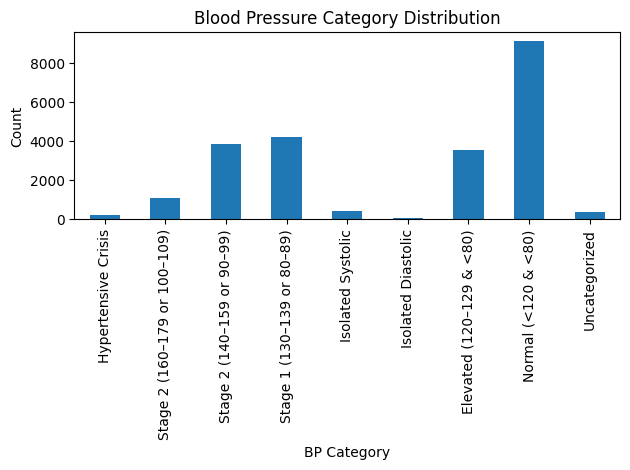

{'counts': bp_category_8
 Normal (<120 & <80)             9119
 Stage 1 (130–139 or 80–89)      4239
 Stage 2 (140–159 or 90–99)      3865
 Elevated (120–129 & <80)        3553
 Stage 2 (160–179 or 100–109)    1084
 Isolated Systolic                420
 Uncategorized                    365
 Hypertensive Crisis              222
 Isolated Diastolic                50
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             39.791421
 Stage 1 (130–139 or 80–89)      18.497185
 Stage 2 (140–159 or 90–99)      16.865209
 Elevated (120–129 & <80)        15.503774
 Stage 2 (160–179 or 100–109)     4.730113
 Isolated Systolic                1.832701
 Uncategorized                    1.592704
 Hypertensive Crisis              0.968713
 Isolated Diastolic               0.218179
 Name: proportion, dtype: float64,
 'imbalance_ratio': 182.38,
 'category_series': 9416       Stage 2 (140–159 or 90–99)
 7473              Normal (<120 & <80)
 19865      Stage 2 (140–159 or

In [22]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_test_trimmed_2, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

### Preparing on the model side to perform on those 
> we are going to make the distribution is balanced on the stage of the real world applications and the observation of those to see ; 
>> so we make some of the trimmming to apply on those to check the overall variance on the models and how muhc change happens

In [23]:
import pandas as pd

# Example semi-balanced target (edit these as you like)
target = pd.Series({
    "Normal (<120 & <80)": 0.40,
    "Elevated (120–129 & <80)": 0.15,
    "Stage 1 (130–139 or 80–89)": 0.15,
    "Stage 2 (140–159 or 90–99)": 0.20,
    "Stage 2 (160–179 or 100–109)": 0.05,
    "Isolated Systolic": 0.03,
    "Isolated Diastolic": 0.01,
    "Hypertensive Crisis": 0.01,
    "Uncategorized": 0.00,
})
target /= target.sum()  # just to be safe

# Trim TRAIN (downsample only; rare classes will stay as-is)
df_train_trim = trim_to_target_proportions(
    df_train_safe, 
    cat_col="bp_category_8", 
    target_props=target, 
    random_state=123, 
    strict=False  # allow total size to shrink if needed
)

# Trim TEST to the same target
df_test_trim = trim_to_target_proportions(
    df_test_trimmed_2, 
    cat_col="bp_category_8", 
    target_props=target, 
    random_state=123, 
    strict=False
)
df_val_trim = trim_to_target_proportions(
    df_val_safe, 
    cat_col="bp_category_8", 
    target_props=target, 
    random_state=123, 
    strict=False
)


> after the trims; there is the some of the subcategories to understand the data variation considered Systolic and Dialostic blood pressure 

    - in below there is the plots to show those trimmed sets for the model training/evaulation

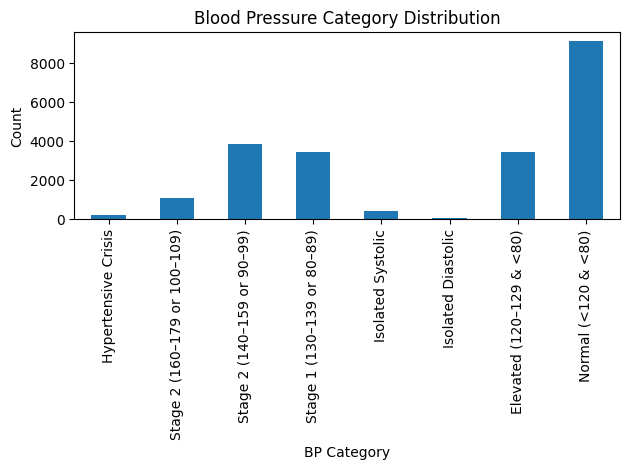

{'counts': bp_category_8
 Normal (<120 & <80)             9119
 Stage 2 (140–159 or 90–99)      3865
 Stage 1 (130–139 or 80–89)      3438
 Elevated (120–129 & <80)        3438
 Stage 2 (160–179 or 100–109)    1084
 Isolated Systolic                420
 Hypertensive Crisis              222
 Isolated Diastolic                50
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             42.147347
 Stage 2 (140–159 or 90–99)      17.863746
 Stage 1 (130–139 or 80–89)      15.890183
 Elevated (120–129 & <80)        15.890183
 Stage 2 (160–179 or 100–109)     5.010168
 Isolated Systolic                1.941209
 Hypertensive Crisis              1.026068
 Isolated Diastolic               0.231096
 Name: proportion, dtype: float64,
 'imbalance_ratio': 182.38,
 'category_series': 15756    Stage 2 (160–179 or 100–109)
 12710    Stage 2 (160–179 or 100–109)
 2651         Elevated (120–129 & <80)
 9785         Elevated (120–129 & <80)
 12828      Stage 1 (130–139 or 80

In [24]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_test_trim, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

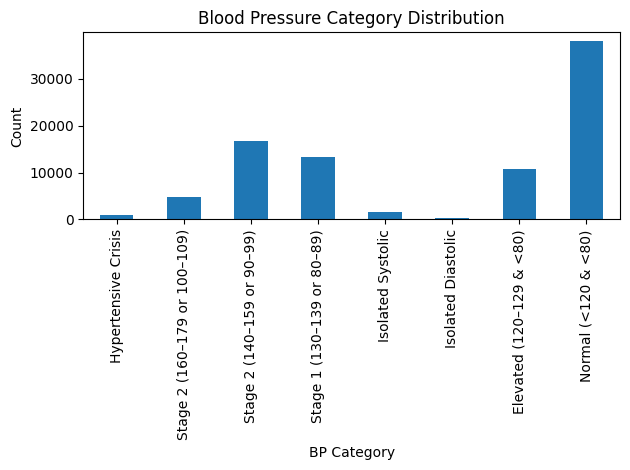

{'counts': bp_category_8
 Normal (<120 & <80)             38038
 Stage 2 (140–159 or 90–99)      16773
 Stage 1 (130–139 or 80–89)      13316
 Elevated (120–129 & <80)        10872
 Stage 2 (160–179 or 100–109)     4755
 Isolated Systolic                1571
 Hypertensive Crisis               951
 Isolated Diastolic                308
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             43.931904
 Stage 2 (140–159 or 90–99)      19.371939
 Stage 1 (130–139 or 80–89)      15.379285
 Elevated (120–129 & <80)        12.556592
 Stage 2 (160–179 or 100–109)     5.491777
 Isolated Systolic                1.814423
 Hypertensive Crisis              1.098355
 Isolated Diastolic               0.355724
 Name: proportion, dtype: float64,
 'imbalance_ratio': 123.5,
 'category_series': 29865    Stage 1 (130–139 or 80–89)
 6044     Stage 2 (140–159 or 90–99)
 1691            Normal (<120 & <80)
 54845    Stage 1 (130–139 or 80–89)
 4803            Normal (<120 & <80

In [25]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_train_trim, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

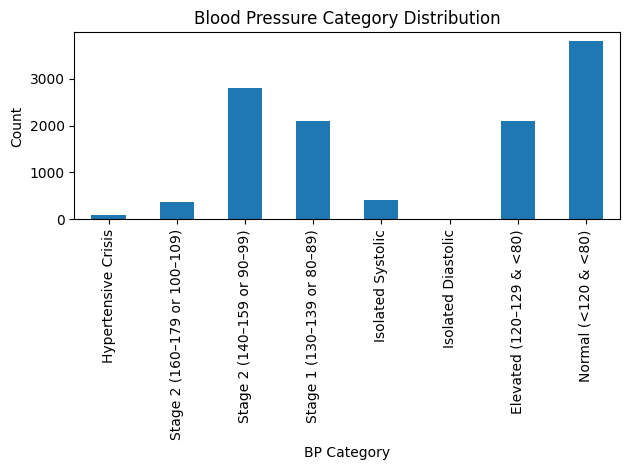

{'counts': bp_category_8
 Normal (<120 & <80)             3794
 Stage 2 (140–159 or 90–99)      2803
 Stage 1 (130–139 or 80–89)      2102
 Elevated (120–129 & <80)        2102
 Isolated Systolic                407
 Stage 2 (160–179 or 100–109)     380
 Hypertensive Crisis               98
 Isolated Diastolic                11
 Name: count, dtype: int64,
 'percents': bp_category_8
 Normal (<120 & <80)             32.435667
 Stage 2 (140–159 or 90–99)      23.963409
 Stage 1 (130–139 or 80–89)      17.970420
 Elevated (120–129 & <80)        17.970420
 Isolated Systolic                3.479525
 Stage 2 (160–179 or 100–109)     3.248696
 Hypertensive Crisis              0.837822
 Isolated Diastolic               0.094041
 Name: proportion, dtype: float64,
 'imbalance_ratio': 344.90909090909093,
 'category_series': 8259       Stage 1 (130–139 or 80–89)
 9738              Normal (<120 & <80)
 7248         Elevated (120–129 & <80)
 1624              Normal (<120 & <80)
 1456         Elevated

In [26]:
custom_schema = [
    ("Hypertensive Crisis", lambda s, d: s >= 180 or d >= 120),
    ("Stage 2 (160–179 or 100–109)", lambda s, d: (160 <= s <= 179) or (100 <= d <= 109)),
    ("Stage 2 (140–159 or 90–99)",  lambda s, d: (140 <= s <= 159) or (90  <= d <= 99)),
    ("Stage 1 (130–139 or 80–89)",  lambda s, d: (130 <= s <= 139) or (80  <= d <= 89)),
    ("Isolated Systolic",           lambda s, d: (s >= 130 and d < 80)),
    ("Isolated Diastolic",          lambda s, d: (d >= 80 and s < 130)),
    ("Elevated (120–129 & <80)",    lambda s, d: (120 <= s <= 129) and d < 80),
    ("Normal (<120 & <80)",         lambda s, d: s < 120 and d < 80),
]
res = analyze_bp_balance(df_val_trim, "sbp", "dbp", out_col="bp_category_8", plot=True, mutate=True, schema=custom_schema)
res

-------------

### how much subject is reamining still ? (after Trim)

In [27]:
# Run the check
subject_leakage_check = check_subject_leakage(df_train_trim, df_val_trim, df_test_trim)

# Format for display
leakage_df = pd.DataFrame({
    "Train ∩ Val": [subject_leakage_check["train ∩ val"]],
    "Train ∩ Test": [subject_leakage_check["train ∩ test"]],
    "Val ∩ Test": [subject_leakage_check["val ∩ test"]],
    "Train Subjects": [subject_leakage_check["subjects_in_train"]],
    "Val Subjects": [subject_leakage_check["subjects_in_val"]],
    "Test Subjects": [subject_leakage_check["subjects_in_test"]],
})

leakage_df

95 14 28


Train ∩ Val Train ∩ Test Val ∩ Test  \
0          {}           {}         {}   

                                      Train Subjects  \
0  {3000397, 3208668, 3210318, 3102350, 3104446, ...   

                                        Val Subjects  \
0  {3002921, 3205889, 3106152, 3101960, 3200359, ...   

                                       Test Subjects  
0  {3206481, 3203264, 3207227, 3108389, 3101354, ...

segment_id

In [29]:
df_test_segment = df_test_trim["segment_id"]

In [30]:
df_test_segment

15756    3201669_0003
12710    3200529_0003
2651     3103148_0005
9785     3108389_0005
12828    3200529_0003
             ...     
25461    3209805_0009
18162    3204143_0001
24237    3209651_0003
11057    3002634_0004
12302    3200529_0003
Name: segment_id, Length: 21636, dtype: object

In [31]:
abp_raw_test = df_test_trim["abp_raw"]

In [32]:
abp_raw_test = abp_raw_test.to_list()

> this is the point of the exemination of the this match for the processing the workload on the formation and for the next step 

- we should analyze that for understanding on te columns to the work on ; 
    - consider that step and then the model preprocessing steps catch the point on the intervals and is there any spesific mismatch is continues 

------------------

> CUDA check 
- required to use with the cuda processing tool on the environment 

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [34]:


# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)

# Get the current CUDA device if available
if cuda_available:
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
    print("Device Count:", torch.cuda.device_count())
    print("Current Device Index:", torch.cuda.current_device())


CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 5070 Ti Laptop GPU
Device Count: 1
Current Device Index: 0


-------------------

### For model preprocessing

>> we are going to change the relatively balanced test sets to process on that intervals. so we are going to use this ones to perform on those 

raw ppg considered ( from dataframe )

In [35]:
import pandas as pd
import numpy as np

### prefferred to use raw ppg / norm ppg  ---- raw selected 
# Assuming df_train_safe is already loaded
ppg_train = df_train_trim['raw_ppg'].tolist()
abp_train = df_train_trim['bp_pair'].tolist()

# Convert validation data
ppg_val = df_val_trim['raw_ppg'].tolist()
abp_val = df_val_trim['bp_pair'].tolist()

# Convert test data
ppg_test = df_test_trim['raw_ppg'].tolist()
abp_test = df_test_trim['bp_pair'].tolist()



deep check 
> make change on the ovrerall length if you change the window size 


In [36]:
def inspect_signal_lists(ppg_list, abp_list, name="Dataset"):
    print(f"\n🔍 Inspecting {name}:")
    errors = {
        "none": 0,
        "type": 0,
        "nan": 0,
        "inf": 0,
        "length": 0,
        "total": 0
    }

    for idx, (ppg, abp) in enumerate(zip(ppg_list, abp_list)):
        errors["total"] += 1
        has_issue = False

        if ppg is None or abp is None:
            errors["none"] += 1
            print(f"❌ Index {idx}: None value found")
            continue

        if not isinstance(ppg, (list, np.ndarray)) or not isinstance(abp, (list, np.ndarray)):
            errors["type"] += 1
            print(f"❌ Index {idx}: Type mismatch — PPG: {type(ppg)}, ABP: {type(abp)}")
            continue

        ppg = np.array(ppg)
        abp = np.array(abp)

        if np.isnan(ppg).any() or np.isnan(abp).any():
            errors["nan"] += 1
            print(f"❌ Index {idx}: Contains NaN")

        if np.isinf(ppg).any() or np.isinf(abp).any():
            errors["inf"] += 1
            print(f"❌ Index {idx}: Contains Inf")

        if len(ppg) != 120 or len(abp) != 2:
            errors["length"] += 1
            print(f"❌ Index {idx}: Incorrect length — PPG: {len(ppg)}, ABP: {len(abp)}")

    print(f"✅ Done checking {name}. Summary:")
    print(f"   Total samples checked: {errors['total']}")
    print(f"   None values:           {errors['none']}")
    print(f"   Type mismatches:       {errors['type']}")
    print(f"   NaN values:            {errors['nan']}")
    print(f"   Inf values:            {errors['inf']}")
    print(f"   Incorrect lengths:     {errors['length']}")


In [37]:
inspect_signal_lists(ppg_train, abp_train, "Train Set")
inspect_signal_lists(ppg_val, abp_val, "Validation Set")
inspect_signal_lists(ppg_test, abp_test, "Test Set")



🔍 Inspecting Train Set:
✅ Done checking Train Set. Summary:
   Total samples checked: 86584
   None values:           0
   Type mismatches:       0
   NaN values:            0
   Inf values:            0
   Incorrect lengths:     0

🔍 Inspecting Validation Set:
✅ Done checking Validation Set. Summary:
   Total samples checked: 11697
   None values:           0
   Type mismatches:       0
   NaN values:            0
   Inf values:            0
   Incorrect lengths:     0

🔍 Inspecting Test Set:
✅ Done checking Test Set. Summary:
   Total samples checked: 21636
   None values:           0
   Type mismatches:       0
   NaN values:            0
   Inf values:            0
   Incorrect lengths:     0


In [38]:
def remove_nan_samples(ppg_list, abp_list):
    cleaned_ppg = []
    cleaned_abp = []
    removed_indices = []

    for idx, (ppg, abp) in enumerate(zip(ppg_list, abp_list)):
        ppg = np.array(ppg)
        abp = np.array(abp)

        if not np.isnan(ppg).any() and not np.isnan(abp).any():
            cleaned_ppg.append(ppg)
            cleaned_abp.append(abp)
        else:
            removed_indices.append(idx)

    print(f"🧹 Removed {len(removed_indices)} samples with NaNs.")
    return cleaned_ppg, cleaned_abp, removed_indices


In [39]:
# directly remove the nan situation on the case 
ppg_train, abp_train, train_removed = remove_nan_samples(ppg_train, abp_train)
ppg_val, abp_val, val_removed = remove_nan_samples(ppg_val, abp_val)
ppg_test, abp_test, test_removed = remove_nan_samples(ppg_test, abp_test)


🧹 Removed 0 samples with NaNs.
🧹 Removed 0 samples with NaNs.
🧹 Removed 0 samples with NaNs.


In [41]:
"""
This code block checks the before of the shuffling matchment between the abp pairs and the raw abp waveforms. 
hence I can compare the after shuffling for the same matchment considered or not 

"""
# Before shuffling, verify all lists are aligned 
print("Lengths before shuffle:")
print(f"ppg_test: {len(ppg_test)}")
print(f"abp_test: {len(abp_test)}")
print(f"df_test_segment: {len(df_test_segment)}")
print(f"abp_raw_test: {len(abp_raw_test)}")

# Check if they're the same length
assert len(ppg_test) == len(abp_test) == len(df_test_segment) == len(abp_raw_test), "Lists must have same length"

# Verify a few samples are aligned (check if abp matches abp_raw max/min)
for i in range(min(5, len(abp_test))):
    abp_pair = abp_test[i]  # [sbp, dbp]
    abp_raw = abp_raw_test[i]  # raw waveform
    
    if isinstance(abp_raw, (list, np.ndarray)):
        sbp_expected = np.max(abp_raw)
        dbp_expected = np.min(abp_raw)
        print(f"Sample {i}: ABP pair {abp_pair} vs Raw max/min [{sbp_expected:.1f}, {dbp_expected:.1f}]")

Lengths before shuffle:
ppg_test: 21636
abp_test: 21636
df_test_segment: 21636
abp_raw_test: 21636
Sample 0: ABP pair [165.625   76.5625] vs Raw max/min [165.6, 76.6]
Sample 1: ABP pair [164.40925598  95.88097382] vs Raw max/min [164.4, 95.9]
Sample 2: ABP pair [120.79147339  62.17854309] vs Raw max/min [120.8, 62.2]
Sample 3: ABP pair [125.67588043  76.48986816] vs Raw max/min [125.7, 76.5]
Sample 4: ABP pair [89.18933105 88.99395752] vs Raw max/min [89.2, 89.0]


clean 

> shuffling those on the different seeds

In [42]:
import random

# ---- Shuffle TRAIN (seed = 42) ----
combined_train = list(zip(ppg_train, abp_train))
random.seed(42)
random.shuffle(combined_train)
ppg_train, abp_train = zip(*combined_train)
ppg_train = list(ppg_train)
abp_train = list(abp_train)

# ---- Shuffle VAL (seed = 99) ----
combined_val = list(zip(ppg_val, abp_val))
random.seed(99)
random.shuffle(combined_val)
ppg_val, abp_val = zip(*combined_val)
ppg_val = list(ppg_val)
abp_val = list(abp_val)

# # ---- Shuffle TEST (seed = 2024) ---- (this is seperated form on the below )


In [43]:
import random
import numpy as np

def safe_shuffle_aligned_lists(*lists, seed=42):
    """
    Safely shuffle multiple lists while maintaining alignment.
    Returns shuffled lists in the same order.
    """
    # Verify all lists have same length
    lengths = [len(lst) for lst in lists]
    assert all(l == lengths[0] for l in lengths), f"All lists must have same length, got: {lengths}"
    
    # Create combined tuples
    combined = list(zip(*lists))
    
    # Shuffle with seed
    random.seed(seed)
    random.shuffle(combined)
    
    # Unpack back to separate lists
    if len(lists) == 1:
        return [list(combined)]
    else:
        return [list(items) for items in zip(*combined)]

# Usage:
ppg_test, abp_test, segment_id_test, abp_raw_test = safe_shuffle_aligned_lists(
    ppg_test, abp_test, df_test_segment, abp_raw_test, seed=2024
)

#### shuffle the test part securing the match of the values 

In [44]:
import numpy as np

ATOL = 1e-6  # tolerance for float compare

def _to_1d(x):
    """Flatten a row (handles list-of-lists, None) into a 1D float array."""
    if isinstance(x, (list, tuple)) and x and hasattr(x[0], "__iter__"):
        flat = []
        for seg in x:
            if seg is None:
                continue
            if hasattr(seg, "__iter__"):
                flat.extend(seg)
            else:
                flat.append(seg)
        return np.asarray(flat, dtype=float)
    return np.asarray(x, dtype=float)

mismatches = []
shape_issues = []

n_raw  = len(abp_raw_test)
n_pair = len(abp_test)
assert n_raw == n_pair, "Length mismatch: abp_raw_test and abp_test must match."

for i in range(n_raw):
    arr  = _to_1d(abp_raw_test[i])
    pair = np.asarray(abp_test[i], dtype=float)

    # require pair == (sbp, dbp)
    if pair.shape != (2,):
        shape_issues.append((i, pair.shape))
        continue

    # skip completely empty rows (or all-NaN)
    if arr.size == 0 or np.isnan(arr).all():
        mismatches.append((i, "empty-or-all-NaN"))
        continue

    mx = np.nanmax(arr)
    mn = np.nanmin(arr)
    sbp, dbp = float(pair[0]), float(pair[1])

    if not (np.isclose(sbp, mx, atol=ATOL) and np.isclose(dbp, mn, atol=ATOL)):
        mismatches.append((i, sbp, mx, dbp, mn))

# --- report ---
if shape_issues:
    print(f"[WARN] {len(shape_issues)} rows had non-(2,) abp_test shapes (showing up to 5):")
    for r in shape_issues[:5]:
        print(f"  idx={r[0]} shape={r[1]}")

if mismatches:
    # if some entries are "empty-or-all-NaN", they’ll only have 2 fields
    detailed = [m for m in mismatches if len(m) == 5]
    empties  = [m for m in mismatches if len(m) == 2]

    if detailed:
        print(f"[WARN] {len(detailed)} rows where abp_test != (max(raw), min(raw))")
        print("  [idx, sbp, max(raw), dbp, min(raw)] (showing up to 10)")
        for r in detailed[:10]:
            print(" ", r)

    if empties:
        print(f"[INFO] {len(empties)} rows were empty or all-NaN (showing up to 10):")
        for r in empties[:10]:
            print(" ", r[0])

    ok = n_raw - len(mismatches) - len(shape_issues)
    if ok > 0:
        print(f"[OK] {ok} rows matched exactly.")
else:
    if shape_issues:
        print("[OK] All comparable rows matched; some skipped due to shape issues above.")
    else:
        print("[OK] Every row matches: abp_test[i] == (max(raw_i), min(raw_i)).")


[OK] Every row matches: abp_test[i] == (max(raw_i), min(raw_i)).


In [45]:
abp_test[0]

array([141.43284607,  67.11173248])

In [46]:
abp_raw_test

[[83.93362426757812,
  83.87501525878906,
  83.7577896118164,
  83.4647216796875,
  83.23027038574219,
  82.87859344482422,
  82.4096908569336,
  81.94078826904297,
  81.35466003417969,
  80.7685317993164,
  80.24101257324219,
  79.59627532958984,
  79.01014709472656,
  78.36540222167969,
  77.72066497802734,
  77.13453674316406,
  76.48979187011719,
  75.9036636352539,
  75.31753540039062,
  74.73140716552734,
  74.26250457763672,
  73.7349853515625,
  73.20747375488281,
  72.79718017578125,
  72.26966857910156,
  71.9179916381836,
  71.56631469726562,
  71.27324676513672,
  71.0387954711914,
  70.86296081542969,
  70.62850952148438,
  70.39405059814453,
  70.15959930419922,
  69.9251480102539,
  69.6906967163086,
  69.39763641357422,
  69.1631851196289,
  68.8701171875,
  68.69428253173828,
  68.40121459960938,
  68.16676330566406,
  67.87370300292969,
  67.58063507080078,
  67.34618377685547,
  67.11173248291016,
  67.11173248291016,
  67.8150863647461,
  69.9251480102539,
  74.2625

In [47]:
ppg_train

[array([ 0.11331312,  0.11239268,  0.10857718,  0.1019389 ,  0.09332201,
         0.08331838,  0.07266769,  0.06198239,  0.05182292,  0.04245049,
         0.0342731 ,  0.02723669,  0.02145221,  0.01669892,  0.01274973,
         0.00933421,  0.00619941,  0.00324318,  0.00040324, -0.00231348,
        -0.00497127, -0.00767064, -0.0105391 , -0.01363581, -0.0169343 ,
        -0.02029012, -0.02351095, -0.02647876, -0.02907828, -0.03133655,
        -0.03327513, -0.03497468, -0.03655757, -0.03821867, -0.04015796,
        -0.04268107, -0.04582232, -0.04962057, -0.05381971, -0.05813539,
        -0.06224393, -0.06597502, -0.06917851, -0.07188377, -0.07382632,
        -0.07469341, -0.07366912, -0.06987326, -0.06251704, -0.05084264,
        -0.03535265, -0.01628168,  0.00460217,  0.02592771,  0.04609991,
         0.06383333,  0.07828806,  0.08924061,  0.09641341,  0.1005429 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [48]:
ppg_test

[array([ 1.01360285,  1.00276303,  0.97103298,  0.92056841,  0.85631472,
         0.78050977,  0.69509023,  0.60300469,  0.50628895,  0.40854719,
         0.31291202,  0.22210371,  0.13843814,  0.06357041, -0.00244535,
        -0.05831663, -0.10570498, -0.14388035, -0.17481257, -0.19918214,
        -0.21864006, -0.23477489, -0.24879469, -0.26197249, -0.27510464,
        -0.28888327, -0.3039715 , -0.32078335, -0.33936268, -0.35923937,
        -0.37920779, -0.39739245, -0.4125016 , -0.42302379, -0.42899361,
        -0.43092087, -0.42989862, -0.42731494, -0.42400604, -0.42058325,
        -0.41731399, -0.41457036, -0.41313037, -0.41435879, -0.41925323,
        -0.42875129, -0.44071603, -0.45044464, -0.45004576, -0.42847639,
        -0.37440997, -0.28171024, -0.14403814,  0.02805316,  0.22632964,
         0.42948687,  0.61896461,  0.77791589,  0.89683485,  0.9689256 ,
         1.0020442 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [49]:
segment_id_test

['3203291_0001',
 '3204143_0001',
 '3204143_0001',
 '3203264_0002',
 '3204143_0001',
 '3106727_0005',
 '3106727_0005',
 '3106727_0005',
 '3103807_0003',
 '3105336_0006',
 '3203291_0001',
 '3108389_0005',
 '3108714_0001',
 '3103807_0003',
 '3105502_0003',
 '3209651_0003',
 '3108714_0001',
 '3209805_0009',
 '3211104_0002',
 '3102184_0007',
 '3204143_0001',
 '3103148_0005',
 '3108714_0001',
 '3103148_0005',
 '3106727_0005',
 '3206481_0004',
 '3108389_0005',
 '3207227_0004',
 '3204143_0001',
 '3002634_0004',
 '3203264_0002',
 '3103148_0005',
 '3103148_0005',
 '3101354_0002',
 '3201669_0003',
 '3108389_0005',
 '3206518_0001',
 '3211235_0001',
 '3209651_0003',
 '3102184_0007',
 '3211235_0001',
 '3108714_0001',
 '3209805_0009',
 '3204143_0001',
 '3200764_0005',
 '3200529_0003',
 '3207227_0004',
 '3108714_0001',
 '3211104_0002',
 '3106727_0005',
 '3103148_0005',
 '3105912_0002',
 '3207227_0004',
 '3200529_0003',
 '3203291_0001',
 '3200764_0005',
 '3103828_0003',
 '3106727_0005',
 '3209651_0003

----------------------

### 3 channel processing on the formation 

In [50]:
import numpy as np
import torch

def compute_derivatives(ppg_signal):
    """Compute first and second derivatives with edge handling."""
    N = len(ppg_signal)
    
    # First derivative (Velocity PPG)
    vpg = np.zeros(N)
    vpg[0] = ppg_signal[1] - ppg_signal[0]
    vpg[1:-1] = (ppg_signal[2:] - ppg_signal[:-2]) / 2
    vpg[-1] = ppg_signal[-1] - ppg_signal[-2]

    # Second derivative (Acceleration PPG)
    apg = np.zeros(N)
    apg[0] = ppg_signal[2] - 2 * ppg_signal[1] + ppg_signal[0]  # forward difference
    apg[1:-1] = ppg_signal[2:] - 2 * ppg_signal[1:-1] + ppg_signal[:-2]  # central difference
    apg[-1] = ppg_signal[-1] - 2 * ppg_signal[-2] + ppg_signal[-3]  # backward difference

    return vpg, apg

def ppg_to_three_channel_tensor(ppg_list, dtype=torch.float32):
    """
    Converts a list of 1D numpy arrays (PPG signals) into a 3D tensor
    with shape (num_samples, 3, signal_length).
    """
    tensor_list = []

    for ppg in ppg_list:
        vpg, apg = compute_derivatives(ppg)
        stacked = np.stack([ppg, vpg, apg], axis=0)  # Shape: (3, L)
        tensor_list.append(torch.tensor(stacked, dtype=dtype))

    return torch.stack(tensor_list)  # Shape: (N, 3, L)


In [51]:
ppg_tensor_train = ppg_to_three_channel_tensor(ppg_train)
print(ppg_tensor_train.shape)  # Expected: (batch_size, 3, signal_length)

ppg_tensor_val = ppg_to_three_channel_tensor(ppg_val)
print(ppg_tensor_val.shape)  # Expected: (batch_size, 3, signal_length)

ppg_tensor_test = ppg_to_three_channel_tensor(ppg_test)
print(ppg_tensor_test.shape)  # Expected: (batch_size, 3, signal_length)

torch.Size([86584, 3, 120])
torch.Size([11697, 3, 120])
torch.Size([21636, 3, 120])


In [52]:
ppg_tensor_test

tensor([[[ 1.0136,  1.0028,  0.9710,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0108, -0.0213, -0.0411,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0209, -0.0209, -0.0187,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4109,  0.4049,  0.3905,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0060, -0.0102, -0.0193,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0085, -0.0085, -0.0097,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.1422,  1.1329,  1.1047,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0094, -0.0187, -0.0357,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0188, -0.0188, -0.0152,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.6667,  0.6514,  0.6196,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0152, -0.0235, -0.0388,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0166, -0.0166, -0.0138,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5024,  0.4954,  0.4715,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0070, -0.0155, -0.0311,  ...,  0.0000,  0.

In [53]:
df_test_safe

norm_ppg  \
0      [1.0, 0.9923401474952698, 0.9717060923576355, ...   
1      [1.0, 0.9924919605255127, 0.9682204127311707, ...   
2      [0.9577745199203491, 0.9443651437759399, 0.915...   
3      [1.0, 0.9936443567276001, 0.9723814725875854, ...   
4      [0.9564376473426819, 0.9443494081497192, 0.920...   
...                                                  ...   
28023  [1.0, 0.9949896335601807, 0.9745521545410156, ...   
28024  [0.9230728149414062, 0.911346435546875, 0.8850...   
28025  [1.0, 0.9909089803695679, 0.9695823192596436, ...   
28026  [0.8705289959907532, 0.8592585921287537, 0.834...   
28027  [1.0, 0.9843520522117615, 0.9423285722732544, ...   

                                                 raw_ppg         sbp  \
0      [0.5624096393585205, 0.555824339389801, 0.5380...  125.871254   
1      [0.40117669105529785, 0.39644119143486023, 0.3...  129.290344   
2      [0.5236141681671143, 0.5106876492500305, 0.483...  118.495796   
3      [0.13719548285007477, 0.13557091355323792, 0.1...  123.673271   
4      [0.5178124904632568, 0.5063748955726624, 0.484...  124.405937   
...                                                  ...         ...   
28023  [0.9463739395141602, 0.9387648701667786, 0.907...  111.754982   
28024  [0.9330135583877563, 0.9151555895805359, 0.875...  121.250252   
28025  [1.2132242918014526, 1.1956729888916016, 1.154...  102.376945   
28026  [0.7815637588500977, 0.7645214796066284, 0.727...  128.479156   
28027  [1.1148277521133423, 1.0888402462005615, 1.019...  117.225510   

             dbp    segment_id  \
0      69.993599  3101354_0002   
1      78.883232  3101354_0002   
2      70.970482  3101354_0002   
3      77.124840  3101354_0002   
4      75.757202  3101354_0002   
...          ...           ...   
28023  58.729980  3211235_0001   
28024  64.356804  3211235_0001   
28025  49.234715  3211235_0001   
28026  65.489983  3211235_0001   
28027  61.738766  3211235_0001   

                                                 abp_raw  \
0      [74.2430419921875, 73.5103759765625, 72.973091...   
1      [79.61589050292969, 79.61589050292969, 79.6158...   
2      [73.90113067626953, 73.55921936035156, 73.1684...   
3      [79.0297622680664, 79.12744903564453, 79.42051...   
4      [78.24825286865234, 77.85750579833984, 77.4667...   
...                                                  ...   
28023  [67.60004425048828, 67.05298614501953, 66.5059...   
28024  [74.00836944580078, 73.38316345214844, 72.7579...   
28025  [56.033790588378906, 55.48674011230469, 54.939...   
28026  [75.2978515625, 74.75080108642578, 74.32096862...   
28027  [70.92143249511719, 70.37438201904297, 69.7882...   

                  bp_category_8                                   bp_pair  
0      Elevated (120–129 & <80)   [125.87125396728516, 69.99359893798828]  
1                 Uncategorized   [129.29034423828125, 78.88323211669922]  
2           Normal (<120 & <80)    [118.49579620361328, 70.9704818725586]  
3      Elevated (120–129 & <80)   [123.67327117919922, 77.12483978271484]  
4      Elevated (120–129 & <80)    [124.40593719482422, 75.7572021484375]  
...                         ...                                       ...  
28023       Normal (<120 & <80)       [111.7549819946289, 58.72998046875]  
28024  Elevated (120–129 & <80)   [121.25025177001953, 64.35680389404297]  
28025       Normal (<120 & <80)   [102.37694549560547, 49.23471450805664]  
28026  Elevated (120–129 & <80)   [128.47915649414062, 65.48998260498047]  
28027       Normal (<120 & <80)  [117.22550964355469, 61.738765716552734]  

[28028 rows x 8 columns]

-----------------------

### Standardization & normalization 

1 channel 

In [59]:
def z_score_normalize_safe(data_list, eps=1e-8):
    normalized = []
    for x in data_list:
        std = np.std(x)
        if std < eps:
            # Flat signal, just return zeros
            normalized.append(np.zeros_like(x))
        else:
            normalized.append((x - np.mean(x)) / std)
    return normalized

3 channel  - preferred (first and second derivative of PPG included )

In [54]:
def z_score_normalize_3channel(data_tensor, eps=1e-8):
    """
    Normalize each (3, L) tensor in the batch independently using z-score,
    channel-wise.
    
    Input: list of torch tensors or a single torch tensor of shape (N, 3, L)
    Output: normalized tensor of the same shape
    """
    if isinstance(data_tensor, list):
        data_tensor = torch.stack(data_tensor)  # (N, 3, L)

    # Compute mean and std over the last dimension (signal length), keep dims for broadcasting
    mean = data_tensor.mean(dim=-1, keepdim=True)
    std = data_tensor.std(dim=-1, keepdim=True)

    # Avoid division by zero
    std = torch.where(std < eps, torch.ones_like(std), std)

    return (data_tensor - mean) / std


In [55]:
ppg_train_z = z_score_normalize_3channel(ppg_tensor_train)
ppg_val_z   = z_score_normalize_3channel(ppg_tensor_val)
ppg_test_z  = z_score_normalize_3channel(ppg_tensor_test)

## we not going to use the normalization on the output . . . 
# abp_train_z = z_score_normalize_safe(abp_train)
# abp_val_z   = z_score_normalize_safe(abp_val)
# abp_test_z  = z_score_normalize_safe(abp_test)


In [56]:
abp_train

[array([132.22763062, 120.82870483]),
 array([151.31903076,  68.43058777]),
 array([127.34375,  64.0625 ]),
 array([135.14285278, 135.14285278]),
 array([115.625,  43.75 ]),
 array([138.13113403,  60.3224678 ]),
 array([128.12773132,  50.58290482]),
 array([111.65762329,  57.68488693]),
 array([158.59375,  61.71875]),
 array([130.64808655,  77.25176239]),
 array([126.56210327,  63.74980164]),
 array([153.125 ,  70.3125]),
 array([107.35934448,  61.69010544]),
 array([92.53036499, 85.96570587]),
 array([140.57333374,  74.09650421]),
 array([155.62451172,  66.56229401]),
 array([66.49287415, 66.49287415]),
 array([160.9375, 101.5625]),
 array([118.75 ,  65.625]),
 array([135.2086792 ,  93.38565826]),
 array([148.75946045,  62.1882515 ]),
 array([151.41671753,  44.93657684]),
 array([153.51701355,  78.49247742]),
 array([126.5625 ,  42.96875]),
 array([82.54653931, 71.16586304]),
 array([157.57107544,  70.48204041]),
 array([136.81233215,  70.43319702]),
 array([117.12815857,  47.6230011 

This is the raw abp considered sbp and dbp pairs 

In [57]:
from torch.utils.data import Dataset

class PPGABPDataset(Dataset):
    def __init__(self, ppg_list, abp_list):
        self.ppg = ppg_list
        self.abp = abp_list

    def __len__(self):
        return len(self.ppg)

    def __getitem__(self, idx):
        ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)
        
        
        abp_tensor = torch.tensor(self.abp[idx], dtype=torch.float32)  # Shape: (3750,)
        return ppg_tensor, abp_tensor


applied the dataset cluster for prepared sets 

In [58]:
from torch.utils.data import DataLoader


#------------------------ train -----------------------------------------
train_dataset = PPGABPDataset(ppg_train_z, abp_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


#------------------------ test and validation -----------------------------------------

val_dataset = PPGABPDataset(ppg_val_z, abp_val)
test_dataset = PPGABPDataset(ppg_test_z, abp_test)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [59]:
x, y = train_dataset[0]

C:\Users\taayd\AppData\Local\Temp\ipykernel_12180\2838761725.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)


In [60]:
print(f"Full train dataset shape: ({len(train_dataset)}, {x.shape[0]}, {x.shape[1] if x.ndim > 1 else 1})")


Full train dataset shape: (86584, 3, 120)


In [61]:
y

tensor([132.2276, 120.8287])

In [62]:
print(f"Full dataset shape (approx): ({len(train_dataset)}, {y.shape[0]}, {y.shape[1] if y.ndim > 1 else 1})")


Full dataset shape (approx): (86584, 2, 1)


In [63]:
ppg_batch, abp_batch = next(iter(train_loader))
print(f"PPG batch shape: {ppg_batch.shape}")  # Expect (batch_size, 1, 3750)
print(f"ABP batch shape: {abp_batch.shape}")  # Expect (batch_size, 3750)

PPG batch shape: torch.Size([128, 3, 120])
ABP batch shape: torch.Size([128, 2])


C:\Users\taayd\AppData\Local\Temp\ipykernel_12180\2838761725.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)


------------------------

### model design 

In [64]:

class PPGtoABPRegressor(nn.Module):
    def __init__(self, input_length=120):  # set to 120 for your dataset
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=15, padding=7),
            nn.BatchNorm1d(16), nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=15, padding=7),
            nn.BatchNorm1d(32), nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv1d(32, 64, kernel_size=15, padding=7),
            nn.BatchNorm1d(64), nn.ReLU(),

            # ---- step-by-step decrease (taper) ----
            nn.Conv1d(64, 32, kernel_size=15, padding=7),
            nn.BatchNorm1d(32), nn.ReLU(),
            nn.Dropout(0.4), # increased dropout this is not worked well 

            nn.Conv1d(32, 16, kernel_size=15, padding=7),
            nn.BatchNorm1d(16), nn.ReLU(),

            nn.Conv1d(16, 1, kernel_size=1),

            nn.Flatten(),                 # -> (batch, input_length)
            nn.Linear(input_length, 2)    # -> (batch, 2)
        )

    def forward(self, x):
        return self.model(x)

In [65]:
for batch_idx, (ppg_batch, abp_batch) in enumerate(train_loader):
    #Deep inspection of the failing batch
    if torch.isnan(ppg_batch).any():
        print(f"PPG NaN → Batch {batch_idx}")
        for i, sample in enumerate(ppg_batch):
            if torch.isnan(sample).any():
                print(f"  - Sample {i} has NaN")
                print(f"    Raw: {sample}")
    elif torch.isnan(abp_batch).any():
        print(f"ABP NaN → Batch {batch_idx}")
        for i, sample in enumerate(abp_batch):
            if torch.isnan(sample).any():
                print(f"  - Sample {i} has NaN")
                print(f"    Raw: {sample}")


C:\Users\taayd\AppData\Local\Temp\ipykernel_12180\2838761725.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)


In [66]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    criterion = nn.L1Loss()  # MAE instead of MSE
    with torch.no_grad():
        for ppg_batch, abp_batch in dataloader:
            ppg_batch, abp_batch = ppg_batch.to(device), abp_batch.to(device)
            preds = model(ppg_batch)
            loss = criterion(preds, abp_batch)
            total_loss += loss.item() * ppg_batch.size(0)

    return total_loss / len(dataloader.dataset)


--------------------------------------

### Model training and plotting

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PPGtoABPRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss()
criterion = nn.L1Loss() # Using MAE for regression tasks
num_epochs = 60
#-----------------------------------------------------------------------

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for ppg_batch, abp_batch in train_loader:
        ppg_batch, abp_batch = ppg_batch.to(device), abp_batch.to(device)
        optimizer.zero_grad()
        preds = model(ppg_batch)
        loss = criterion(preds, abp_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * ppg_batch.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation loss
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss) 

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")


C:\Users\taayd\AppData\Local\Temp\ipykernel_12180\2838761725.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)


Epoch 1/60, Train Loss: 80.7540, Val Loss: 66.4337
Epoch 2/60, Train Loss: 45.1997, Val Loss: 27.0294
Epoch 3/60, Train Loss: 17.7709, Val Loss: 12.0823
Epoch 4/60, Train Loss: 12.9913, Val Loss: 11.7520
Epoch 5/60, Train Loss: 12.4766, Val Loss: 11.0804
Epoch 6/60, Train Loss: 12.1266, Val Loss: 11.2722
Epoch 7/60, Train Loss: 11.8537, Val Loss: 11.0269
Epoch 8/60, Train Loss: 11.5733, Val Loss: 10.8025
Epoch 9/60, Train Loss: 11.3675, Val Loss: 11.4308
Epoch 10/60, Train Loss: 11.1974, Val Loss: 11.3767
Epoch 11/60, Train Loss: 11.0089, Val Loss: 11.1332
Epoch 12/60, Train Loss: 10.8829, Val Loss: 11.4017
Epoch 13/60, Train Loss: 10.7639, Val Loss: 11.1812
Epoch 14/60, Train Loss: 10.6659, Val Loss: 11.3109
Epoch 15/60, Train Loss: 10.5647, Val Loss: 11.5965
Epoch 16/60, Train Loss: 10.4904, Val Loss: 11.6851
Epoch 17/60, Train Loss: 10.4199, Val Loss: 11.6483
Epoch 18/60, Train Loss: 10.3128, Val Loss: 11.4805
Epoch 19/60, Train Loss: 10.2389, Val Loss: 11.3976
Epoch 20/60, Train Lo

----------------------------------

#### Model saving 
> for any situation

In [68]:
import os

os.makedirs("models", exist_ok=True)

torch.save(model.state_dict(), "models/ppg_to_abp_cnn_subject_137_segment_137_fixed_row_1000.pth")
print("Model saved to models/ppg_to_abp_cnn_subject_137_segment_137_fixed_row_1000.pth")


Model saved to models/ppg_to_abp_cnn_subject_137_segment_137_fixed_row_1000.pth


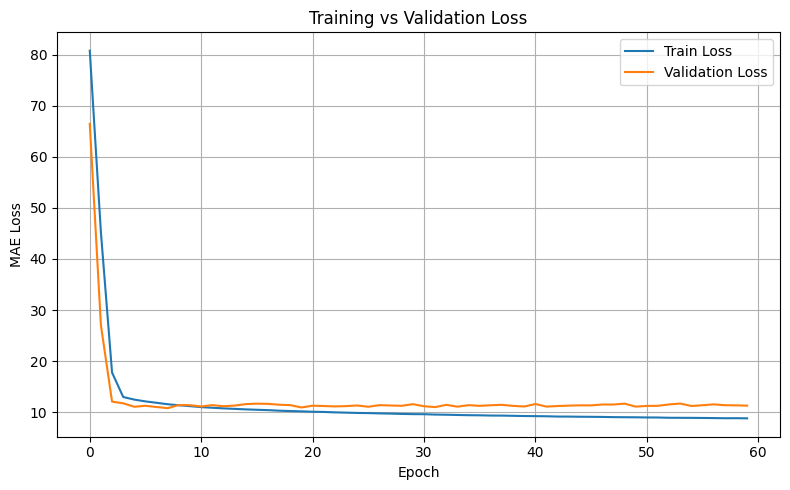

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


> validation prediction with the plot 

In [70]:
def plot_preds(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for ppg_batch, abp_batch in val_loader:
            ppg_batch, abp_batch = ppg_batch.to(device), abp_batch.to(device)
            preds = model(ppg_batch)

            # Take first sample from batch to plot
            pred_np = preds[0].cpu().numpy()
            target_np = abp_batch[0].cpu().numpy()

            plt.figure(figsize=(10, 4))
            plt.plot(target_np, label="True ABP")
            plt.plot(pred_np, label="Predicted ABP", alpha=0.7)
            plt.title("Predicted vs True ABP Signal")
            plt.xlabel("Sample Index")
            plt.ylabel("ABP (mmHg)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            break  # Just show one batch


In [71]:
import torch

def inspect_batches(loader, num_batches=1, num_samples=1):
    """
    Inspect a few batches and samples from a DataLoader.
    
    Args:
        loader: PyTorch DataLoader yielding (ppg_batch, abp_batch).
        num_batches: Number of batches to inspect.
        num_samples: Number of samples per batch to display.
    """
    for b_idx, (ppg_batch, abp_batch) in enumerate(loader):
        print(f"\n📦 Batch {b_idx+1}/{len(loader)}")
        print(f"  ppg_batch shape: {ppg_batch.shape}")  # (B, C, T) or (B, T)
        print(f"  abp_batch shape: {abp_batch.shape}")  # (B, T)

        # Loop over a few samples in the batch
        for s_idx in range(min(num_samples, ppg_batch.shape[0])):
            ppg_sample = ppg_batch[s_idx]
            abp_sample = abp_batch[s_idx]

            print(f"   ▶ Sample {s_idx+1}:")
            print(f"     PPG sample shape: {ppg_sample.shape}")
            print(f"     ABP sample shape: {abp_sample.shape}")
            print(f"     First 5 PPG values: {ppg_sample.flatten()[:5].numpy()}")
            print(f"     First 5 ABP values: {abp_sample[:5].numpy()}")

        if b_idx + 1 >= num_batches:
            break


In [72]:
inspect_batches(val_loader, num_batches=3, num_samples=2)


📦 Batch 1/92
  ppg_batch shape: torch.Size([128, 3, 120])
  abp_batch shape: torch.Size([128, 2])
   ▶ Sample 1:
     PPG sample shape: torch.Size([3, 120])
     ABP sample shape: torch.Size([2])
     First 5 PPG values: [2.7784834 2.7069128 2.563592  2.364534  2.1342282]
     First 5 ABP values: [135.7866   65.98839]
   ▶ Sample 2:
     PPG sample shape: torch.Size([3, 120])
     ABP sample shape: torch.Size([2])
     First 5 PPG values: [3.0375047 2.974261  2.826863  2.614875  2.3661776]
     First 5 ABP values: [125.051956  60.885353]

📦 Batch 2/92
  ppg_batch shape: torch.Size([128, 3, 120])
  abp_batch shape: torch.Size([128, 2])
   ▶ Sample 1:
     PPG sample shape: torch.Size([3, 120])
     ABP sample shape: torch.Size([2])
     First 5 PPG values: [2.8614209 2.812196  2.6889918 2.5089676 2.2983148]
     First 5 ABP values: [152.63783  56.41494]
   ▶ Sample 2:
     PPG sample shape: torch.Size([3, 120])
     ABP sample shape: torch.Size([2])
     First 5 PPG values: [2.219228  

C:\Users\taayd\AppData\Local\Temp\ipykernel_12180\2838761725.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)


after the shape check ; there is the data formation toi represent 

In [73]:
import torch
import numpy as np
import pandas as pd

def dataloader_to_dataframe_simple(model, loader, device):
    """
    For each sample in the loader, create one DataFrame row with:
      - ppg, vpg, apg: full 1D sequences (lists)
      - abp: full target sequence (list)
      - pred: full predicted sequence (list)
      - mae_int: integer MAE over the full waveform
    Assumes inputs are shaped (B, 3, T) and targets (B, T).
    """
    model.eval()
    rows = []

    with torch.no_grad():
        for X, Y in loader:               # X: (B, 3, T), Y: (B, T)
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)              # (B, T)

            B, C, T = X.shape
            assert C == 3, f"Expected 3 channels (ppg,vpg,apg), got {C}"

            for b in range(B):
                # split channels
                ppg = X[b, 0].detach().cpu().numpy()
                vpg = X[b, 1].detach().cpu().numpy()
                apg = X[b, 2].detach().cpu().numpy()

                abp = Y[b].detach().cpu().numpy()
                pred = preds[b].detach().cpu().numpy()

                mae = float(np.mean(np.abs(pred - abp)))  # average over all 3750 points

                rows.append({
                    "ppg": ppg.tolist(),
                    "vpg": vpg.tolist(),
                    "apg": apg.tolist(),
                    "abp": abp.tolist(),
                    "pred": pred.tolist(),
                    "mae_int": int(round(mae))
                })

    return pd.DataFrame(rows)


In [74]:
df = dataloader_to_dataframe_simple(model, test_loader, device)
print(df.shape)
df.head()


C:\Users\taayd\AppData\Local\Temp\ipykernel_12180\2838761725.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ppg_tensor = torch.tensor(self.ppg[idx], dtype=torch.float32)  # Shape: (3, 3750)


(21636, 6)


ppg  \
0  [2.8089449405670166, 2.7787423133850098, 2.690...   
1  [2.7177956104278564, 2.6788792610168457, 2.585...   
2  [2.9782555103302, 2.9534006118774414, 2.878680...   
3  [2.7565462589263916, 2.7107832431793213, 2.592...   
4  [2.617244243621826, 2.6045026779174805, 2.5809...   

                                                 vpg  \
0  [-0.028807247057557106, -0.15695874392986298, ...   
1  [-0.07478681951761246, -0.19886215031147003, -...   
2  [0.0024549770168960094, -0.11256233602762222, ...   
3  [-0.10161862522363663, -0.2657988369464874, -0...   
4  [0.0417100265622139, 0.018379706889390945, -0....   

                                                 apg  \
0  [-0.15694019198417664, -0.15694019198417664, -...   
1  [-0.17156711220741272, -0.17156711220741272, -...   
2  [-0.15340206027030945, -0.15340206027030945, -...   
3  [-0.21042375266551971, -0.21042375266551971, -...   
4  [-0.03152928873896599, -0.03152928873896599, -...   

                                       abp  \
0  [141.43284606933594, 67.11173248291016]   
1  [142.72247314453125, 74.78032684326172]   
2   [158.0595245361328, 80.54393005371094]   
3   [141.5620574951172, 67.49978637695312]   
4   [155.0800323486328, 77.36906433105469]   

                                       pred  mae_int  
0  [108.74942779541016, 51.923004150390625]       24  
1   [159.46749877929688, 74.83185577392578]        8  
2   [138.98109436035156, 73.61378479003906]       13  
3    [126.1070556640625, 64.32353210449219]        9  
4   [136.57281494140625, 74.00894927978516]       11

In [75]:
import numpy as np

# Convert dataframe column and numpy array to lists
abp_list = df["abp"].to_list()

# Row-by-row comparison (Boolean list)
comparison = [np.array_equal(a, b) for a, b in zip(abp_list, abp_test)]

if all(comparison):
    print("✅ All abp values match row by row.")
else:
    mismatches = [
        {"row": i, "df_abp": abp_list[i], "abp_test": abp_test[i]}
        for i, same in enumerate(comparison) if not same
    ]
    print("❌ Mismatches found in these rows:")
    for m in mismatches:
        print(m)


"""
what I learn:
after the to list formation to the numpy array transformation, we should not compare whole dataframe directly , we should do row it by row from starting one of them to other . . . 
>> on that point , tihs proves to us that segment id consideratation on the side of the same continuity. On the loaders and database formation changers which comes with torhc not shuffle the data after the batch by batch preparing of the model. this is small but important shows the analyze the data for the next steps 
"""

✅ All abp values match row by row.


'\nwhat I learn:\nafter the to list formation to the numpy array transformation, we should not compare whole dataframe directly , we should do row it by row from starting one of them to other . . . \n>> on that point , tihs proves to us that segment id consideratation on the side of the same continuity. On the loaders and database formation changers which comes with torhc not shuffle the data after the batch by batch preparing of the model. this is small but important shows the analyze the data for the next steps \n'

In [76]:
abp_list

[[141.43284606933594, 67.11173248291016],
 [142.72247314453125, 74.78032684326172],
 [158.0595245361328, 80.54393005371094],
 [141.5620574951172, 67.49978637695312],
 [155.0800323486328, 77.36906433105469],
 [175.93646240234375, 84.54914093017578],
 [152.29591369628906, 62.7158317565918],
 [170.12400817871094, 79.1762924194336],
 [124.01518249511719, 67.94214630126953],
 [82.35115814208984, 40.88251495361328],
 [132.2306365966797, 57.79228591918945],
 [118.2027359008789, 68.43058776855469],
 [152.7355194091797, 56.805694580078125],
 [104.86829376220703, 57.58720016479492],
 [185.02146911621094, 104.13562774658203],
 [134.375, 60.9375],
 [146.82537841796875, 56.07303237915039],
 [127.43426513671875, 53.33776092529297],
 [124.6989974975586, 51.72590637207031],
 [133.4420928955078, 64.13230895996094],
 [160.55056762695312, 86.35637664794922],
 [121.13337707519531, 58.1733283996582],
 [138.61956787109375, 51.04208755493164],
 [144.6273956298828, 65.79300689697266],
 [175.20379638671875, 79

In [77]:
abp_test

[array([141.43284607,  67.11173248]),
 array([142.72247314,  74.78032684]),
 array([158.05952454,  80.54393005]),
 array([141.5620575 ,  67.49978638]),
 array([155.08003235,  77.36906433]),
 array([175.9364624 ,  84.54914093]),
 array([152.2959137 ,  62.71583176]),
 array([170.12400818,  79.17629242]),
 array([124.0151825,  67.9421463]),
 array([82.35115814, 40.88251495]),
 array([132.2306366 ,  57.79228592]),
 array([118.2027359 ,  68.43058777]),
 array([152.73551941,  56.80569458]),
 array([104.86829376,  57.58720016]),
 array([185.02146912, 104.13562775]),
 array([134.375 ,  60.9375]),
 array([146.82537842,  56.07303238]),
 array([127.43426514,  53.33776093]),
 array([124.6989975 ,  51.72590637]),
 array([133.4420929 ,  64.13230896]),
 array([160.55056763,  86.35637665]),
 array([121.13337708,  58.1733284 ]),
 array([138.61956787,  51.04208755]),
 array([144.62739563,  65.7930069 ]),
 array([175.20379639,  79.90895081]),
 array([131.25   ,  50.78125]),
 array([98.03012085, 65.548789

In [78]:
df["segment_id"] = segment_id_test

In [79]:
df["abp_raw"] = abp_raw_test

In [80]:
df

ppg  \
0      [2.8089449405670166, 2.7787423133850098, 2.690...   
1      [2.7177956104278564, 2.6788792610168457, 2.585...   
2      [2.9782555103302, 2.9534006118774414, 2.878680...   
3      [2.7565462589263916, 2.7107832431793213, 2.592...   
4      [2.617244243621826, 2.6045026779174805, 2.5809...   
...                                                  ...   
21631  [2.031827926635742, 2.0235066413879395, 2.0005...   
21632  [2.437983512878418, 2.4204163551330566, 2.3825...   
21633  [3.1073758602142334, 3.03368878364563, 2.87970...   
21634  [2.8068690299987793, 2.7675538063049316, 2.634...   
21635  [3.032789468765259, 2.874195098876953, 2.56773...   

                                                     vpg  \
0      [-0.028807247057557106, -0.15695874392986298, ...   
1      [-0.07478681951761246, -0.19886215031147003, -...   
2      [0.0024549770168960094, -0.11256233602762222, ...   
3      [-0.10161862522363663, -0.2657988369464874, -0...   
4      [0.0417100265622139, 0.018379706889390945, -0....   
...                                                  ...   
21631  [0.04749447852373123, 0.007207257207483053, -0...   
21632  [0.018244806677103043, -0.04350997507572174, -...   
21633  [-0.16814473271369934, -0.31329724192619324, -...   
21634  [-0.056391406804323196, -0.2245517522096634, -...   
21635  [-0.44805529713630676, -0.6970207095146179, -1...   

                                                     apg  \
0      [-0.15694019198417664, -0.15694019198417664, -...   
1      [-0.17156711220741272, -0.17156711220741272, -...   
2      [-0.15340206027030945, -0.15340206027030945, -...   
3      [-0.21042375266551971, -0.21042375266551971, -...   
4      [-0.03152928873896599, -0.03152928873896599, -...   
...                                                  ...   
21631  [-0.04793030023574829, -0.04793030023574829, -...   
21632  [-0.0762719064950943, -0.0762719064950943, -0....   
21633  [-0.1775633543729782, -0.1775633543729782, -0....   
21634  [-0.20954978466033936, -0.20954978466033936, -...   
21635  [-0.31823620200157166, -0.31823620200157166, -...   

                                           abp  \
0      [141.43284606933594, 67.11173248291016]   
1      [142.72247314453125, 74.78032684326172]   
2       [158.0595245361328, 80.54393005371094]   
3       [141.5620574951172, 67.49978637695312]   
4       [155.0800323486328, 77.36906433105469]   
...                                        ...   
21631  [155.86154174804688, 67.79561614990234]   
21632  [128.26461791992188, 61.78779220581055]   
21633   [114.4905776977539, 38.19609069824219]   
21634  [128.70420837402344, 51.72590637207031]   
21635    [131.2495880126953, 71.2497787475586]   

                                           pred  mae_int    segment_id  \
0      [108.74942779541016, 51.923004150390625]       24  3203291_0001   
1       [159.46749877929688, 74.83185577392578]        8  3204143_0001   
2       [138.98109436035156, 73.61378479003906]       13  3204143_0001   
3        [126.1070556640625, 64.32353210449219]        9  3203264_0002   
4       [136.57281494140625, 74.00894927978516]       11  3204143_0001   
...                                         ...      ...           ...   
21631    [130.04415893554688, 52.1025276184082]       21  3103148_0005   
21632     [122.0982437133789, 43.7676887512207]       12  3103148_0005   
21633   [113.48454284667969, 57.21919250488281]       10  3211104_0002   
21634   [114.90411376953125, 56.20712661743164]        9  3211104_0002   
21635    [139.03990173339844, 74.6268539428711]        6  3002634_0004   

                                                 abp_raw  
0      [83.93362426757812, 83.87501525878906, 83.7577...  
1      [87.72401428222656, 86.99134826660156, 86.1610...  
2      [97.93242645263672, 97.54167938232422, 97.0532...  
3      [75.93726348876953, 74.99976348876953, 74.0622...  
4      [95.97866821289062, 95.4413833618164, 94.75756...  
...                                           

In [81]:
import ast
import numpy as np
import pandas as pd

def parse_arr(x):
    """Safely convert list-like strings/lists/arrays to numpy array."""
    if isinstance(x, np.ndarray):
        return x.astype(float)
    if isinstance(x, (list, tuple)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        return np.asarray(ast.literal_eval(x), dtype=float)
    return np.asarray([x], dtype=float)  # fallback for single numbers

def check_abp_ranges(
    df,
    abp_pair_col="abp",          
    abp_wave_col="abp_raw",      
    sbp_col="sbp",               
    dbp_col="dbp",
    tol=1.0                      
):
    rows = []
    for _, row in df.iterrows():
        # --- SBP/DBP from pair or fallback ---
        if abp_pair_col in df.columns and row[abp_pair_col] is not None:
            pair = parse_arr(row[abp_pair_col])
            if pair.shape[0] == 2:  
                sbp_true, dbp_true = float(pair[0]), float(pair[1])
            else:  # if malformed, fallback
                sbp_true = float(row.get(sbp_col, np.nan))
                dbp_true = float(row.get(dbp_col, np.nan))
        else:
            sbp_true = float(row.get(sbp_col, np.nan))
            dbp_true = float(row.get(dbp_col, np.nan))

        # --- waveform max/min ---
        abp_w = parse_arr(row[abp_wave_col])
        abp_max, abp_min = float(np.max(abp_w)), float(np.min(abp_w))

        # --- diffs & flags ---
        sbp_diff = sbp_true - abp_max
        dbp_diff = dbp_true - abp_min
        sbp_match = abs(sbp_diff) <= tol
        dbp_match = abs(dbp_diff) <= tol
        order_ok  = sbp_true > dbp_true

        rows.append({
            "subject_id": row.get("subject_id", None),
            "segment_id": row.get("segment_id", None),
            "sbp_true": sbp_true,
            "dbp_true": dbp_true,
            "abp_max": abp_max,
            "abp_min": abp_min,
            "sbp_diff": sbp_diff,
            "dbp_diff": dbp_diff,
            "sbp_match": sbp_match,
            "dbp_match": dbp_match,
            "pair_order_ok": order_ok,
        })

    return pd.DataFrame(rows)

def summarize_checks(checked_df):
    """Quick summary counts/percentages of mismatches and order issues."""
    n = len(checked_df)
    sbp_bad = (~checked_df["sbp_match"]).sum()
    dbp_bad = (~checked_df["dbp_match"]).sum()
    any_bad = (~(checked_df["sbp_match"] & checked_df["dbp_match"])).sum()
    order_bad = (~checked_df["pair_order_ok"]).sum()
    return pd.Series({
        "total_rows": n,
        "sbp_mismatch_count": int(sbp_bad),
        "sbp_mismatch_pct": 100.0 * sbp_bad / n if n else 0.0,
        "dbp_mismatch_count": int(dbp_bad),
        "dbp_mismatch_pct": 100.0 * dbp_bad / n if n else 0.0,
        "any_mismatch_count": int(any_bad),
        "any_mismatch_pct": 100.0 * any_bad / n if n else 0.0,
        "pair_order_bad_count": int(order_bad),
        "pair_order_bad_pct": 100.0 * order_bad / n if n else 0.0,
    })


In [82]:
checked = check_abp_ranges(df, abp_pair_col="abp", abp_wave_col="abp_raw", tol=1.0)
print(checked.head())
print(summarize_checks(checked))

  subject_id    segment_id    sbp_true   dbp_true     abp_max    abp_min  \
0       None  3203291_0001  141.432846  67.111732  141.432846  67.111732   
1       None  3204143_0001  142.722473  74.780327  142.722473  74.780327   
2       None  3204143_0001  158.059525  80.543930  158.059525  80.543930   
3       None  3203264_0002  141.562057  67.499786  141.562057  67.499786   
4       None  3204143_0001  155.080032  77.369064  155.080032  77.369064   

   sbp_diff  dbp_diff  sbp_match  dbp_match  pair_order_ok  
0       0.0       0.0       True       True           True  
1       0.0       0.0       True       True           True  
2       0.0       0.0       True       True           True  
3       0.0       0.0       True       True           True  
4       0.0       0.0       True       True           True  
total_rows              21636.000000
sbp_mismatch_count          0.000000
sbp_mismatch_pct            0.000000
dbp_mismatch_count          0.000000
dbp_mismatch_pct            0

-----------------

### Result Saving

#### downsized resutls for the saving under the results folder
> for the github version; we saved the float64 to float16 format for the under the formation to include the sample example for the saving progress; you can directly save the not downsized version too.

In [ ]:
import numpy as np
import pandas as pd
import gzip
import pickle
import os

# columns whose cells are Python lists of float64
seq_cols = ["ppg", "vpg", "apg", "abp", "pred", "abp_raw"]

# ---- create a downsized copy ----
downsized_df = df.copy()

# convert list-of-float64 -> NumPy float16 array for every cell
for col in seq_cols:
    downsized_df[col] = downsized_df[col].apply(
        lambda x: np.asarray(x, dtype=np.float16)
    )

# if 'pred' is always length 2, split it into two pure float32 columns
try:
    pred_arr = np.stack(downsized_df["pred"].to_numpy())  # shape (N, 2)
    downsized_df["SBP_predicted"] = pred_arr[:, 0].astype(np.float16)
    downsized_df["DBP_predicted"] = pred_arr[:, 1].astype(np.float16)
    downsized_df.drop(columns=["pred"], inplace=True)
except Exception:
    # if pred is ragged, just keep it as float16 arrays
    pass

# downcast/categorize scalar columns
downsized_df["segment_id"] = downsized_df["segment_id"].astype("category")

# --- drop mae_int column entirely ---
if "mae_int" in downsized_df.columns:
    downsized_df.drop(columns=["mae_int"], inplace=True)

In [17]:
downsized_df

d:\Anaconda\envs\vtec_env\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


ppg  \
0      [2.809, 2.78, 2.69, 2.549, 2.371, 2.16, 1.922,...   
1      [2.719, 2.68, 2.586, 2.428, 2.21, 1.9375, 1.61...   
2      [2.979, 2.953, 2.879, 2.764, 2.617, 2.436, 2.2...   
3      [2.756, 2.71, 2.592, 2.4, 2.148, 1.856, 1.544,...   
4      [2.617, 2.605, 2.58, 2.549, 2.498, 2.412, 2.26...   
...                                                  ...   
21631  [2.031, 2.023, 2.0, 1.962, 1.909, 1.841, 1.754...   
21632  [2.438, 2.42, 2.383, 2.324, 2.246, 2.152, 2.04...   
21633  [3.107, 3.033, 2.879, 2.658, 2.389, 2.084, 1.7...   
21634  [2.807, 2.768, 2.635, 2.42, 2.15, 1.841, 1.505...   
21635  [3.033, 2.875, 2.568, 2.145, 1.672, 1.198, 0.7...   

                                                     vpg  \
0      [-0.02881, -0.157, -0.4001, -0.5996, -0.755, -...   
1      [-0.07477, -0.1989, -0.4656, -0.7437, -1.008, ...   
2      [0.002455, -0.11255, -0.3206, -0.4868, -0.641,...   
3      [-0.1016, -0.2659, -0.5947, -0.8926, -1.117, -...   
4      [0.04172, 0.01839, -0.02405, -0.08356, -0.1991...   
...                                                  ...   
21631  [0.0475, 0.007206, -0.07526, -0.1577, -0.2411,...   
21632  [0.01825, -0.04352, -0.1696, -0.2896, -0.3997,...   
21633  [-0.1681, -0.3132, -0.5796, -0.788, -0.9414, -...   
21634  [-0.0564, -0.2246, -0.5366, -0.7817, -0.952, -...   
21635  [-0.448, -0.697, -1.143, -1.423, -1.508, -1.43...   

                                                     apg             abp  \
0      [-0.157, -0.157, -0.1406, -0.1034, -0.0865, -0...   [141.4, 67.1]   
1      [-0.1715, -0.1715, -0.1974, -0.1868, -0.1787, ...  [142.8, 74.75]   
2      [-0.1534, -0.1534, -0.1237, -0.0977, -0.10785,...  [158.0, 80.56]   
3      [-0.2104, -0.2104, -0.211, -0.1704, -0.1178, -...   [141.5, 67.5]   
4      [-0.03152, -0.03152, -0.02582, -0.05457, -0.10...   [155.1, 77.4]   
...                                                  ...             ...   
21631  [-0.04794, -0.04794, -0.05017, -0.0479, -0.051...   [155.9, 67.8]   
21632  [-0.0763, -0.0763, -0.07935, -0.06903, -0.0667...  [128.2, 61.78]   
21633  [-0.1776, -0.1776, -0.148, -0.1075, -0.07983, ...   [114.5, 38.2]   
21634  [-0.2096, -0.2096, -0.1791, -0.1259, -0.08545,...  [128.8, 51.72]   
21635  [-0.318, -0.318, -0.2512, -0.10693, -0.002365,...  [131.2, 71.25]   

         segment_id                                            abp_raw  \
0      3203291_0001  [83.94, 83.9, 83.75, 83.44, 83.25, 82.9, 82.44...   
1      3204143_0001  [87.75, 87.0, 86.2, 85.3, 84.4, 83.56, 82.7, 8...   
2      3204143_0001  [97.94, 97.56, 97.06, 96.56, 95.94, 95.3, 94.6...   
3      3203264_0002  [75.94, 75.0, 74.06, 74.06, 73.1, 73.1, 73.1, ...   
4      3204143_0001  [96.0, 95.44, 94.75, 94.0, 93.25, 92.44, 91.56...   
...             ...                                                ...   
21631  3103148_0005  [102.6, 101.94, 101.3, 100.7, 100.06, 99.4, 98...   
21632  3103148_0005  [92.94, 92.1, 91.25, 90.5, 89.75, 89.0, 88.3, ...   
21633  3211104_0002  [54.75, 54.16, 53.62, 53.28, 53.03, 52.66, 51....   
21634  3211104_0002  [69.5, 68.9, 68.06, 67.3, 66.4, 65.4, 64.5, 63...   
21635  3002634_0004  [80.6, 80.6, 80.6, 79.7, 78.75, 78.75, 77.8, 7...   

       SBP_predicted  DBP_predicted  
0            108.750       51.93750  
1            159.500       74.81250  
2            139.000       73.62500  
3            126.125       64.31250  
4            136.625       74.00000  
...              ...            ...  
21631        130.000       52.09375  
21632        122.125       43.78125  
21633        113.500       57.21875  
21634        114.875       56.21875  
21635        139.000       74.62500  

[21636 rows x 8 columns]

In [18]:
import os

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Save as pickle
df_path = os.path.join("results", "ppg_abp_predictions_peak_to_peak_raw_137_subject_137_segment_subject_analyze.pkl") # saved the dataframe with 180096 of the test sample case on hand (segment id included)
downsized_df.to_pickle(df_path)
print(f"✅ DataFrame saved to {df_path}")

✅ DataFrame saved to results\ppg_abp_predictions_peak_to_peak_raw_137_subject_137_segment_subject_analyze.pkl


----------------

### detailed evaulation of the model performance side and saved test results
> now we are going to consider the model effeciency and the overall resutls with the clinical perspective to measure how much difference on the predictions and the values 

- we should consider the MAE and the clinical reports to observe the there is the patern or the some of the predictions is low or high on the target . . . 


In [1]:
#### if we wanted to load this we can use this ; 

import pandas as pd
df_loaded = pd.read_pickle("results/ppg_abp_predictions_peak_to_peak_raw_137_subject_137_segment_subject_analyze.pkl")
print(df_loaded.shape)
df_loaded.head()

(21636, 8)


ppg  \
0  [2.8089449405670166, 2.7787423133850098, 2.690...   
1  [2.7177956104278564, 2.6788792610168457, 2.585...   
2  [2.9782555103302, 2.9534006118774414, 2.878680...   
3  [2.7565462589263916, 2.7107832431793213, 2.592...   
4  [2.617244243621826, 2.6045026779174805, 2.5809...   

                                                 vpg  \
0  [-0.028807247057557106, -0.15695874392986298, ...   
1  [-0.07478681951761246, -0.19886215031147003, -...   
2  [0.0024549770168960094, -0.11256233602762222, ...   
3  [-0.10161862522363663, -0.2657988369464874, -0...   
4  [0.0417100265622139, 0.018379706889390945, -0....   

                                                 apg  \
0  [-0.15694019198417664, -0.15694019198417664, -...   
1  [-0.17156711220741272, -0.17156711220741272, -...   
2  [-0.15340206027030945, -0.15340206027030945, -...   
3  [-0.21042375266551971, -0.21042375266551971, -...   
4  [-0.03152928873896599, -0.03152928873896599, -...   

                                       abp  \
0  [141.43284606933594, 67.11173248291016]   
1  [142.72247314453125, 74.78032684326172]   
2   [158.0595245361328, 80.54393005371094]   
3   [141.5620574951172, 67.49978637695312]   
4   [155.0800323486328, 77.36906433105469]   

                                       pred  mae_int    segment_id  \
0  [108.74942779541016, 51.923004150390625]       24  3203291_0001   
1   [159.46749877929688, 74.83185577392578]        8  3204143_0001   
2   [138.98109436035156, 73.61378479003906]       13  3204143_0001   
3    [126.1070556640625, 64.32353210449219]        9  3203264_0002   
4   [136.57281494140625, 74.00894927978516]       11  3204143_0001   

                                             abp_raw  
0  [83.93362426757812, 83.87501525878906, 83.7577...  
1  [87.72401428222656, 86.99134826660156, 86.1610...  
2  [97.93242645263672, 97.54167938232422, 97.0532...  
3  [75.93726348876953, 74.99976348876953, 74.0622...  
4  [95.97866821289062, 95.4413833618164, 94.75756...

In [2]:
df = df_loaded.copy()  # Use the loaded DataFrame for further processing if needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21636 entries, 0 to 21635
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ppg         21636 non-null  object
 1   vpg         21636 non-null  object
 2   apg         21636 non-null  object
 3   abp         21636 non-null  object
 4   pred        21636 non-null  object
 5   mae_int     21636 non-null  int64 
 6   segment_id  21636 non-null  object
 7   abp_raw     21636 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB


In [86]:
df["abp"]

0        [141.43284606933594, 67.11173248291016]
1        [142.72247314453125, 74.78032684326172]
2         [158.0595245361328, 80.54393005371094]
3         [141.5620574951172, 67.49978637695312]
4         [155.0800323486328, 77.36906433105469]
                          ...                   
21631    [155.86154174804688, 67.79561614990234]
21632    [128.26461791992188, 61.78779220581055]
21633     [114.4905776977539, 38.19609069824219]
21634    [128.70420837402344, 51.72590637207031]
21635      [131.2495880126953, 71.2497787475586]
Name: abp, Length: 21636, dtype: object

-----------

### Distribution for the average mae on the test cases

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mae_count_list_full(df, column="mae_int"):
    """
    Returns a list 'counts' where counts[i] = number of rows with mae_int == i.
    Also returns the x-values used (0..max_mae).
    Does NOT modify df.
    """
    s = df[column].astype(int).to_numpy()
    if s.size == 0:
        return [], []
    max_mae = int(s.max())
    counts = [0] * (max_mae + 1)
    for v in s:
        if v >= 0:
            counts[v] += 1
    x_vals = list(range(max_mae + 1))  # x-axis MAE values
    return counts, x_vals

def mae_count_list_around_mean(df, column="mae_int", radius=5):
    """
    Returns (counts, x_vals, start_mae) for a window around the mean.
    counts[k] corresponds to mae = start_mae + k.
    """
    s = df[column].astype(int).to_numpy()
    if s.size == 0:
        return [], [], None
    mean_int = int(round(np.mean(s)))
    lo = mean_int - radius
    hi = mean_int + radius
    # build dense list lo..hi (inclusive)
    length = hi - lo + 1
    counts = [0] * length
    for v in s:
        if lo <= v <= hi:
            counts[v - lo] += 1
    x_vals = list(range(lo, hi + 1))
    return counts, x_vals, lo

# Optional quick bar-plotter (uses the lists above)
def plot_mae_counts(x_vals, counts, title="Counts per integer MAE", save_path=None):
    plt.figure(figsize=(12, 5))
    plt.bar(x_vals, counts, edgecolor="black")
    plt.xlabel("MAE (mmHg)")
    plt.ylabel("Window Count")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


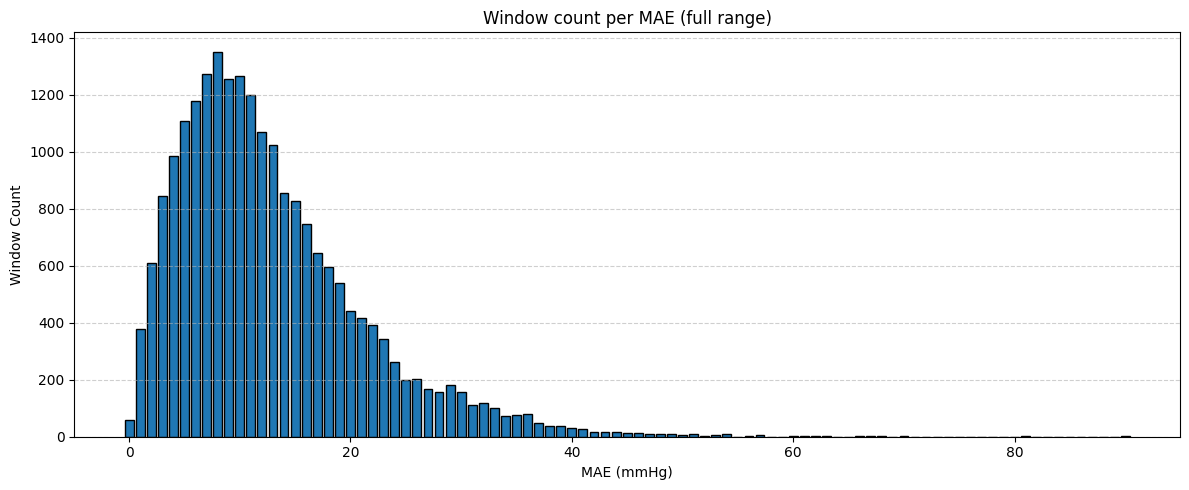

In [90]:
counts, x_vals = mae_count_list_full(df, "mae_int")
# counts[i] = how many samples have mae_int == i
plot_mae_counts(x_vals, counts, title="Window count per MAE (full range)")


---------------------------

### Mean analyzes of the truth and predicted values 
> analyzes of the mean of the truth and predicted difference ; 

In [91]:
import numpy as np
import pandas as pd

def dataframe_to_map_table(df: pd.DataFrame, mmhg_scale: float = 1.0) -> pd.DataFrame:
    """
    Create a new dataframe with MAP (time-average) for truth (ABP) and prediction.
    If your stored values are scaled (e.g., ABP/200), pass mmhg_scale=200 to
    report MAP in mmHg.

    Returns columns:
      - map_true: mean(ABP) * mmhg_scale
      - map_pred: mean(pred) * mmhg_scale
      - map_abs_err: |map_pred - map_true|
      - mae_int: copied from source if present (else NaN)
      - idx: original row index to keep link back
    """
    # Safety: ensure required columns exist
    for col in ["abp", "pred"]:
        if col not in df.columns:
            raise KeyError(f"Missing '{col}' column in input dataframe.")

    def _safe_mean(x):
        arr = np.asarray(x, dtype=float)
        if arr.size == 0:
            return np.nan
        # ignore NaNs if any slipped in
        return np.nanmean(arr)

    map_true = df["abp"].apply(_safe_mean) * mmhg_scale
    map_pred = df["pred"].apply(_safe_mean) * mmhg_scale

    out = pd.DataFrame({
        "idx": df.index,                          # link back to original row
        "map_true": map_true,
        "map_pred": map_pred,
        "map_abs_err": (map_pred - map_true),
        "mae_int": df.get("mae_int", pd.Series([np.nan]*len(df), index=df.index))
    })

    return out.reset_index(drop=True)


def add_map_columns_inplace(df: pd.DataFrame, mmhg_scale: float = 1.0) -> pd.DataFrame:
    """
    Adds MAP columns onto the same dataframe (non-compact).
      - MAP_true
      - MAP_pred
      - MAP_abs_err
    Returns the modified dataframe for convenience.
    """
    table = dataframe_to_map_table(df, mmhg_scale=mmhg_scale).set_index("idx")
    df["MAP_true"] = table["map_true"].reindex(df.index)
    df["MAP_pred"] = table["map_pred"].reindex(df.index)
    df["MAP_abs_err"] = table["map_abs_err"].reindex(df.index)
    return df


In [92]:
# If your stored signals are raw mmHg:
map_df = dataframe_to_map_table(df, mmhg_scale=1.0)

# # If you saved ABP and pred scaled by 1/200 during training:
# map_df = dataframe_to_map_table(df, mmhg_scale=200.0)

# # Or add onto the same dataframe
# df = add_map_columns_inplace(df, mmhg_scale=200.0)

In [93]:
map_df

idx    map_true    map_pred  map_abs_err  mae_int
0          0  104.272289   80.336216   -23.936073       24
1          1  108.751400  117.149677     8.398277        8
2          2  119.301727  106.297440   -13.004288       13
3          3  104.530922   95.215294    -9.315628        9
4          4  116.224548  105.290882   -10.933666       11
...      ...         ...         ...          ...      ...
21631  21631  111.828579   91.073343   -20.755236       21
21632  21632   95.026205   82.932966   -12.093239       12
21633  21633   76.343334   85.351868     9.008533       10
21634  21634   90.215057   85.555620    -4.659437        9
21635  21635  101.249683  106.833378     5.583694        6

[21636 rows x 5 columns]

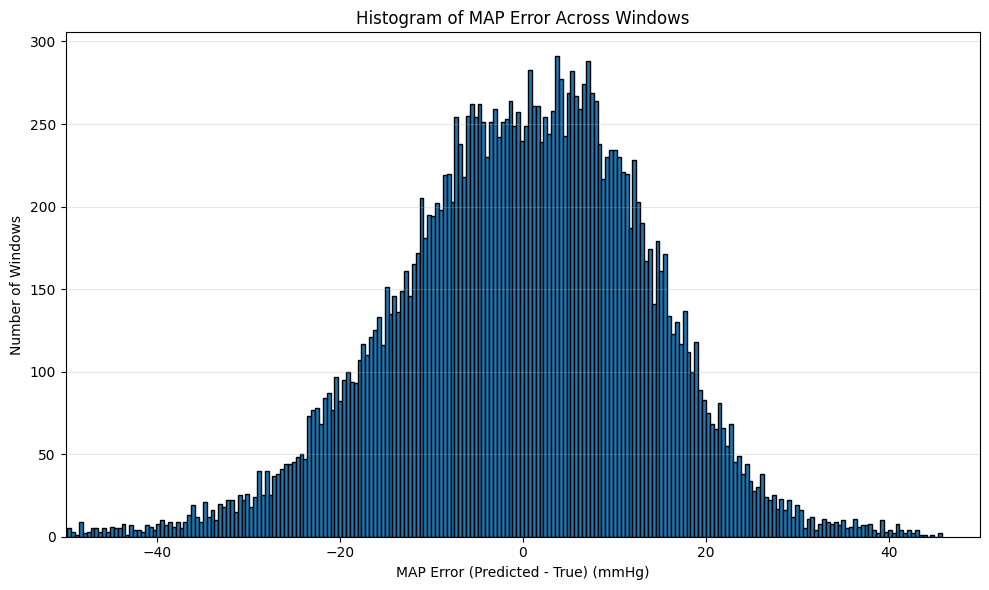

In [94]:
# Increase the number of histogram bins significantly to make it more granular
plt.figure(figsize=(10, 6))

# Signed errors for more detail
signed_errors = map_df["map_pred"] - map_df["map_true"]

# Use a high number of bins for more detailed view
plt.hist(signed_errors, bins=300, edgecolor='black')
plt.xlim(-50, 50)
plt.xlabel("MAP Error (Predicted - True) (mmHg)")
plt.ylabel("Number of Windows")
plt.title("Histogram of MAP Error Across Windows")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


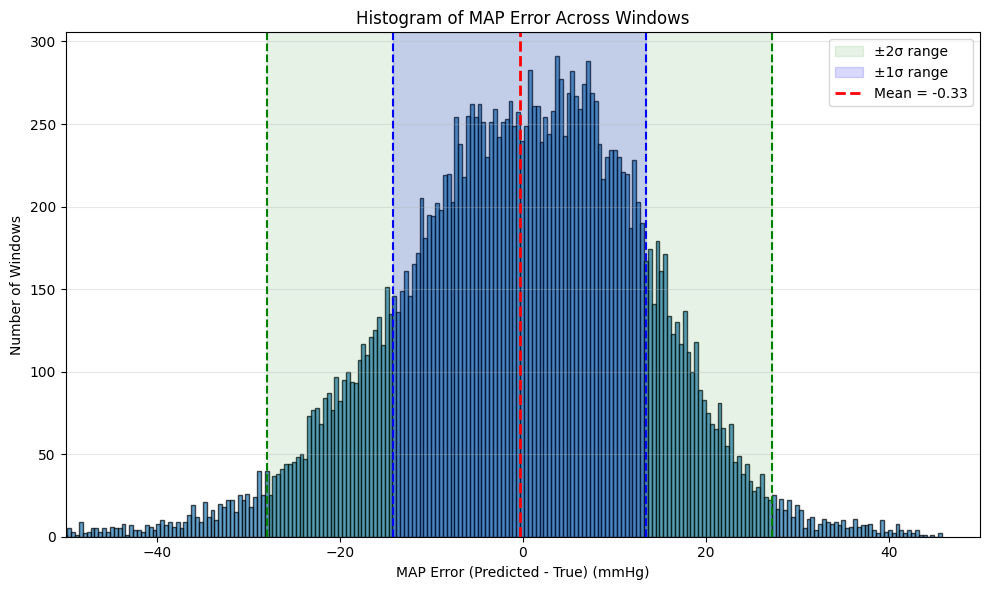

In [95]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Signed errors
signed_errors = map_df["map_pred"] - map_df["map_true"]

# Histogram
plt.hist(signed_errors, bins=300, edgecolor='black', alpha=0.7)
plt.xlim(-50, 50)
plt.xlabel("MAP Error (Predicted - True) (mmHg)")
plt.ylabel("Number of Windows")
plt.title("Histogram of MAP Error Across Windows")
plt.grid(axis='y', alpha=0.3)

# Mean and standard deviation
mean_val = np.mean(signed_errors)
std_val = np.std(signed_errors)

# Bounds
lower_1 = mean_val - std_val
upper_1 = mean_val + std_val
lower_2 = mean_val - 2 * std_val
upper_2 = mean_val + 2 * std_val

# Shading for ±2σ range (light green)
plt.axvspan(lower_2, upper_2, color='green', alpha=0.1, label='±2σ range')

# Shading for ±1σ range (light blue, overrides center part of green)
plt.axvspan(lower_1, upper_1, color='blue', alpha=0.15, label='±1σ range')

# Mean line
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")

# ±1σ lines
plt.axvline(lower_1, color='blue', linestyle='--', linewidth=1.5)
plt.axvline(upper_1, color='blue', linestyle='--', linewidth=1.5)

# ±2σ lines
plt.axvline(lower_2, color='green', linestyle='--', linewidth=1.5)
plt.axvline(upper_2, color='green', linestyle='--', linewidth=1.5)

plt.legend()
plt.tight_layout()
plt.show()


blent-altman formation 

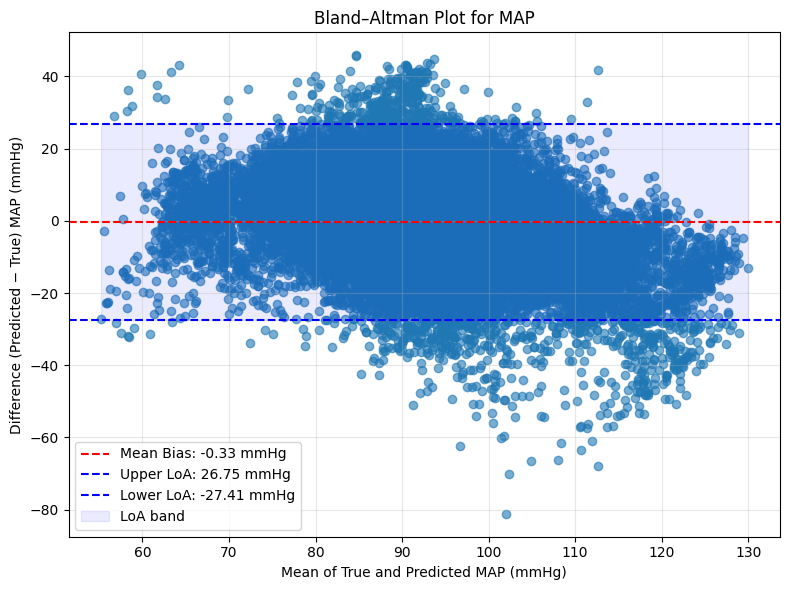

(np.float64(-0.3304903460921364),
 np.float64(26.753860073930213),
 np.float64(-27.414840766114487),
 (np.float64(-0.5146226290262604), np.float64(-0.1463580631580124)),
 (np.float64(26.434933604574663), np.float64(27.072786543285762)),
 (np.float64(-27.733767235470037), np.float64(-27.095914296758938)))

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Get arrays & clean ---
true = map_df["map_true"].to_numpy(dtype=float)
pred = map_df["map_pred"].to_numpy(dtype=float)

# Keep only finite pairs
mask = np.isfinite(true) & np.isfinite(pred)
true = true[mask]
pred = pred[mask]

# --- 2) Bland–Altman inputs ---
diff_values = pred - true                      # y-axis (bias per point)
mean_values = (pred + true) / 2.0              # x-axis (average per point)

# --- 3) Bias and LoA (use SAMPLE SD: ddof=1) ---
n = diff_values.size
mean_diff = np.mean(diff_values)               # mean bias
sd_diff   = np.std(diff_values, ddof=1)        # SD of differences
loa_upper = mean_diff + 1.96 * sd_diff         # Upper limit of agreement
loa_lower = mean_diff - 1.96 * sd_diff         # Lower limit of agreement

# (Optional) 95% CIs
#  - CI for mean bias:
se_bias = sd_diff / np.sqrt(n)
bias_ci = (mean_diff - 1.96 * se_bias, mean_diff + 1.96 * se_bias)

#  - CI for LoA (approx): SE(LoA) ≈ sd_diff * sqrt(3/n)
se_loa = sd_diff * np.sqrt(3.0 / n)
loa_upper_ci = (loa_upper - 1.96 * se_loa, loa_upper + 1.96 * se_loa)
loa_lower_ci = (loa_lower - 1.96 * se_loa, loa_lower + 1.96 * se_loa)

# --- 4) Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, diff_values, alpha=0.6)

# Mean bias & LoA lines
plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Bias: {mean_diff:.2f} mmHg")
plt.axhline(loa_upper, color='blue', linestyle='--', label=f"Upper LoA: {loa_upper:.2f} mmHg")
plt.axhline(loa_lower, color='blue', linestyle='--', label=f"Lower LoA: {loa_lower:.2f} mmHg")

# (Optional) lightly shade the agreement band
plt.fill_between(
    [np.min(mean_values), np.max(mean_values)],
    loa_lower, loa_upper, alpha=0.08, color='blue', label='LoA band'
)

plt.xlabel("Mean of True and Predicted MAP (mmHg)")
plt.ylabel("Difference (Predicted − True) MAP (mmHg)")
plt.title("Bland–Altman Plot for MAP")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

(mean_diff, loa_upper, loa_lower, bias_ci, loa_upper_ci, loa_lower_ci)


--------------------

#### Deep comparison via prediction and bland-Altman plots

SBP and DBP procesing on unit 
> then we are going to compare predicted and actual SBP and DBP to observe on the difference ;
> based on that we are going to evaulate each of the window level and cycle level evaulations to the consider overall analyze 

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21636 entries, 0 to 21635
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ppg         21636 non-null  object
 1   vpg         21636 non-null  object
 2   apg         21636 non-null  object
 3   abp         21636 non-null  object
 4   pred        21636 non-null  object
 5   mae_int     21636 non-null  int64 
 6   segment_id  21636 non-null  object
 7   abp_raw     21636 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB


In [98]:
"""

taking the reference from the previousversion the abp consdiered the (sbp, dbp ) pairs currently ; 
we can observe the clinical acceptance on the interval of the predicted and the actual values. for the sbp and dbp 
"""




'\n\ntaking the reference from the previousversion the abp consdiered the (sbp, dbp ) pairs currently ; \nwe can observe the clinical acceptance on the interval of the predicted and the actual values. for the sbp and dbp \n'

================

In [99]:
import numpy as np
import pandas as pd

def to_pair(x):
    # x can be list/tuple/ndarray like [sbp, dbp] OR a string like "[sbp, dbp]"
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            # parse a simple string list without ast.literal_eval
            parts = x[1:-1].split(',')
            return [float(parts[0]), float(parts[1])]
        # fallback: try splitting on whitespace
        parts = x.replace(',', ' ').split()
        return [float(parts[0]), float(parts[1])]
    # last resort: wrap scalar or unknown types (will likely error if not length-2)
    return list(x)

# Expand into columns
df[['sbp_true','dbp_true']] = pd.DataFrame(df['abp'].apply(to_pair).tolist(), index=df.index)
df[['sbp_pred','dbp_pred']] = pd.DataFrame(df['pred'].apply(to_pair).tolist(), index=df.index)


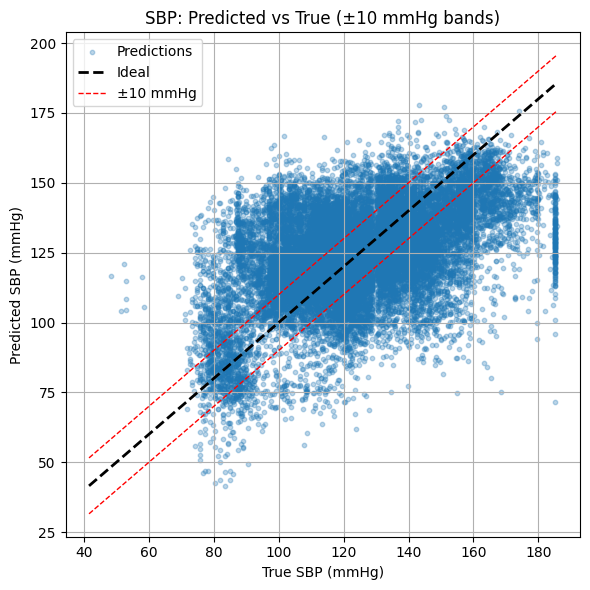

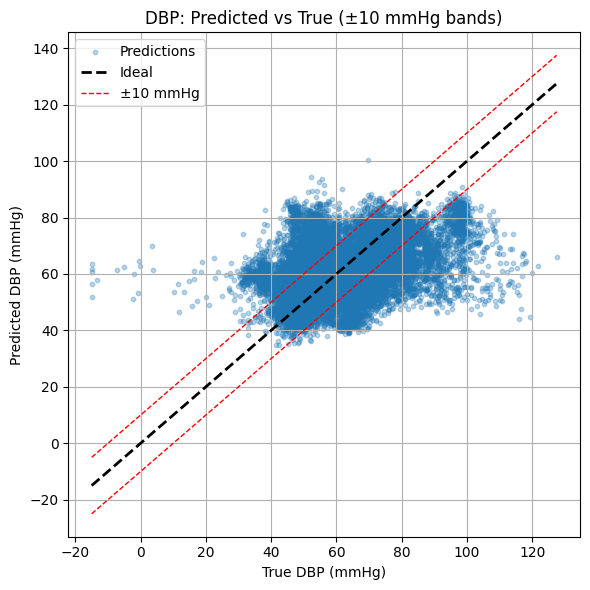

In [100]:
import matplotlib.pyplot as plt

def plot_comparison(true, pred, label, tol=10):
    true = pd.Series(true).astype(float)
    pred = pd.Series(pred).astype(float)

    lo = min(true.min(), pred.min())
    hi = max(true.max(), pred.max())

    plt.figure(figsize=(6,6))
    plt.scatter(true, pred, alpha=0.3, s=10, label="Predictions")
    # Ideal diagonal
    plt.plot([lo, hi], [lo, hi], linestyle='--', linewidth=2, color='k', label="Ideal")
    # ±tol bands
    plt.plot([lo, hi], [lo+tol, hi+tol], linestyle='--', linewidth=1, color='r', label=f"±{tol} mmHg")
    plt.plot([lo, hi], [lo-tol, hi-tol], linestyle='--', linewidth=1, color='r')

    plt.xlabel(f"True {label} (mmHg)")
    plt.ylabel(f"Predicted {label} (mmHg)")
    plt.title(f"{label}: Predicted vs True (±{tol} mmHg bands)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison(df['sbp_true'], df['sbp_pred'], 'SBP', tol=10)
plot_comparison(df['dbp_true'], df['dbp_pred'], 'DBP', tol=10)


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bland_altman(true, pred, label, tol=None, vertical_sd=False):
    """
    Bland–Altman plot.

    x-axis: pairwise mean = (pred + true) / 2
    y-axis: difference     = pred - true

    Lines:
      - Blue solid: mean difference
      - Red dashed: ±1.96 SD (limits of agreement)
      - Red dash-dot: ±1 SD
      - Red dotted: ±2 SD
      - Optional gray dashed: ±tol (fixed tolerance band)
      - Optional gray verticals: mean(x) ± {1,2}·SD(x) to visualize x spread
    """
    true = pd.Series(true, dtype=float).to_numpy()
    pred = pd.Series(pred, dtype=float).to_numpy()

    # Axes
    x = (pred + true) / 2.0
    diff = pred - true

    # Stats
    mean_diff = np.mean(diff)
    sd_diff = np.std(diff, ddof=1)   # sample SD

    # Limits
    loa_hi = mean_diff + 1.96 * sd_diff
    loa_lo = mean_diff - 1.96 * sd_diff
    sd1_hi, sd1_lo = mean_diff + sd_diff, mean_diff - sd_diff
    sd2_hi, sd2_lo = mean_diff + 2 * sd_diff, mean_diff - 2 * sd_diff

    # Optional x-distribution stats
    mean_x = np.mean(x)
    sd_x = np.std(x, ddof=1)

    # Plot
    plt.figure(figsize=(7, 4.5))
    plt.scatter(x, diff, alpha=0.5, s=14)

    # Mean difference (blue)
    plt.axhline(mean_diff, linestyle='-', linewidth=1.2, color='blue',
                label=f"Mean = {mean_diff:.2f}")

    # ±1 SD (red dash-dot)
    plt.axhline(sd1_hi, linestyle='-.', linewidth=1.2, color='red',
                label=f"+1 SD = {sd1_hi:.2f}")
    plt.axhline(sd1_lo, linestyle='-.', linewidth=1.2, color='red',
                label=f"-1 SD = {sd1_lo:.2f}")

    # # ±2 SD (red dotted)
    # plt.axhline(sd2_hi, linestyle=':', linewidth=1.2, color='red',
    #             label=f"+2 SD = {sd2_hi:.2f}")
    # plt.axhline(sd2_lo, linestyle=':', linewidth=1.2, color='red',
    #             label=f"-2 SD = {sd2_lo:.2f}")

    # ±1.96 SD (red dashed)
    plt.axhline(loa_hi, linestyle='--', linewidth=1.2, color='red',
                label=f"+1.96·SD = {loa_hi:.2f}")
    plt.axhline(loa_lo, linestyle='--', linewidth=1.2, color='red',
                label=f"-1.96·SD = {loa_lo:.2f}")

    # # Optional tolerance band (gray)
    # if tol is not None:
    #     plt.axhline(+tol, linestyle='--', linewidth=1, color='gray')
    #     plt.axhline(-tol, linestyle='--', linewidth=1, color='gray')

    # # Optional vertical SD lines (gray)
    # if vertical_sd:
    #     for k, ls in [(0, '-'), (1, '--'), (-1, '--')]:
    #         plt.axvline(mean_x + k * sd_x, linestyle=ls, linewidth=1, color='gray')

    # Right-side annotations
    xr = np.max(x)
    pad = 0.02 * (np.max(diff) - np.min(diff) + 1e-9)
    plt.text(xr, mean_diff + pad, f"Mean: {mean_diff:.3f}", color='blue',
             va='bottom', ha='right', fontsize=8)
    for val, txt in [(sd1_hi, "+1 SD"), (sd1_lo, "-1 SD"),
                     (loa_hi, "+1.96·SD"), (loa_lo, "-1.96·SD")]:
        plt.text(xr, val + pad, f"{txt}: {val:.3f}", color='red',
                 va='bottom' if val >= mean_diff else 'top',
                 ha='right', fontsize=8)

    plt.xlabel(f"Mean of True & Predicted {label}")
    plt.ylabel("Predicted − True")
    plt.title(f"Bland–Altman: {label}")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=8)
    plt.tight_layout()
    plt.show()


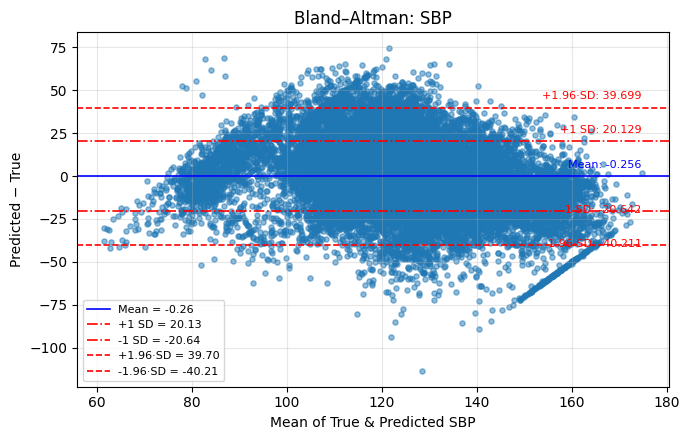

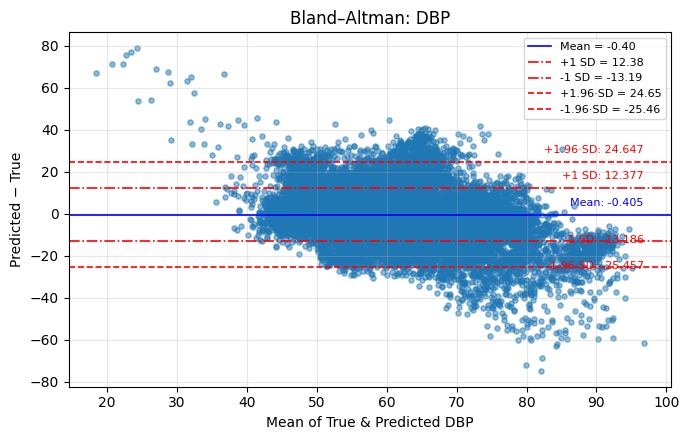

In [102]:
bland_altman(df["sbp_true"], df["sbp_pred"], label="SBP", tol=10, vertical_sd=True)
bland_altman(df["dbp_true"], df["dbp_pred"], label="DBP", tol=10, vertical_sd=True)


---------------------------

## Analyzing the datasets and their predictions to perform the bias and the tests 

> I am planning to deep analyze for the baseline BP and the other underestimation and the higher estimation on the sbp and dbp to check the model optimization and steps 

- we are going to use __df__ use for that spesific formations 

In [86]:
df

ppg  \
0       [2.717369556427002, 2.6859636306762695, 2.5979...   
1       [2.3505003452301025, 2.33341383934021, 2.29638...   
2       [2.448639392852783, 2.4363770484924316, 2.3859...   
3       [2.5555334091186523, 2.5140974521636963, 2.439...   
4       [3.160362958908081, 3.056501626968384, 2.85471...   
...                                                   ...   
245501  [2.4714651107788086, 2.4495606422424316, 2.403...   
245502  [2.5724451541900635, 2.548828363418579, 2.4570...   
245503  [2.204056978225708, 2.140296459197998, 2.00908...   
245504  [2.9494287967681885, 2.897996664047241, 2.7691...   
245505  [3.035856008529663, 2.976928949356079, 2.82333...   

                                                      vpg  \
0       [-0.037277985364198685, -0.15963906049728394, ...   
1       [0.0136796860024333, -0.03999393805861473, -0....   
2       [0.041543636471033096, -0.050691768527030945, ...   
3       [-0.0886831134557724, -0.16309498250484467, -0...   
4       [-0.31614774465560913, -0.5163518190383911, -0...   
...                                                   ...   
245501  [-0.0054920148104429245, -0.06158733740448952,...   
245502  [-0.00673145754262805, -0.148909330368042, -0....   
245503  [-0.1943238228559494, -0.33680152893066406, -0...   
245504  [-0.11152012646198273, -0.27423346042633057, -...   
245505  [-0.1505649983882904, -0.36108461022377014, -0...   

                                                      apg  \
0       [-0.15056730806827545, -0.15056730806827545, -...   
1       [-0.06541179120540619, -0.06541179120540619, -...   
2       [-0.12434931099414825, -0.12434931099414825, -...   
3       [-0.09676341712474823, -0.09676341712474823, -...   
4       [-0.260866641998291, -0.260866641998291, -0.22...   
...                                                   ...   
245501  [-0.07256920635700226, -0.07256920635700226, -...   
245502  [-0.18755365908145905, -0.18755365908145905, -...   
245503  [-0.18923033773899078, -0.18923033773899078, -...   
245504  [-0.1978483498096466, -0.1978483498096466, -0....   
245505  [-0.28650134801864624, -0.28650134801864624, -...   

                                            abp  \
0       [133.40289306640625, 65.99809265136719]   
1       [117.66544342041016, 57.78257369995117]   
2        [98.17708587646484, 56.77083206176758]   
3       [120.67695617675781, 59.06243896484375]   
4        [79.22513580322266, 38.48915481567383]   
...                                         ...   
245501  [128.69778442382812, 67.08326721191406]   
245502           [102.34375, 58.33333206176758]   
245503                         [106.25, 59.375]   
245504   [139.6870574951172, 44.06236267089844]   
245505   [92.75495147705078, 38.19609069824219]   

                                            pred  mae_int    segment_id  \
0          [127.97689819335938, 64.137451171875]        4  3100033_0006   
1          [98.57928466796875, 39.5811653137207]       19  3100503_0007   
2          [112.160400390625, 53.17198181152344]        9  3102930_0008   
3         [154.03201293945312, 74.6104965209961]       24  3102930_0008   
4         [102.23882293701172, 58.0214958190918]       21  3100033_0006   
...                                          ...      ...           ...   
245501    [165.3258514404297, 67.86621856689453]       19  3100033_0008   
245502   [117.67493438720703, 63.43532180786133]       10  3101746_0003   
245503  [123.11548614501953, 60.416019439697266]        9  3101746_0003   
245504    [112.31787872314453, 48.4011116027832]       16  3100033_0006   
245505   [105.19186401367188, 59.31597137451172]       17  3101746_0003   

                                                  abp_raw    sbp_true  \
0       [55.31232833862305, 55.31232833862305, 55.3123...  133.402893   
1       [49.21875, 49.21875, 49.21875, 49.21875, 49.21...  117.665443   
2       [98.37202453613281, 97.29745483398438, 96.2228...   98.177086   
3       [72.43580627441406, 71.65430450439453, 70

In [103]:
import numpy as np
import pandas as pd

def calibrate_sbp_and_compare(
    df,
    segment_col="segment_id",
    abp_col="abp",      # each row like [SBP, DBP]
    pred_col="pred",    # each row like [SBP, DBP]
    subject_extractor=lambda s: str(s).split("_")[0],  # how to get subject_id
    clip_range=(70, 250),   # optional clipping for calibrated SBP
    return_augmented_df=True
):
    """
    Fit a GLOBAL linear calibration for SBP:
        true_sbp ≈ a * pred_sbp + b
    Apply it to all rows and compare pre/post calibration at
    window-level and subject-level.

    Returns:
        calib (dict): {"a": ..., "b": ..., "n": ...}
        win_metrics (pd.Series): overall window-level metrics pre/post
        subj_table (pd.DataFrame): per-subject baselines & bias pre/post
        df_out (pd.DataFrame, optional): original df with added columns:
            ["true_sbp","true_dbp","pred_sbp","pred_dbp","pred_sbp_cal"]
    """
    # ---- safety checks
    for c in [segment_col, abp_col, pred_col]:
        if c not in df.columns:
            raise KeyError(f"Column '{c}' not found in df")

    tmp = df.copy()
    # subject_id
    tmp["subject_id"] = tmp[segment_col].map(subject_extractor)

    # helper extractors
    def _sbp(x): return float(x[0]) if isinstance(x, (list, tuple, np.ndarray)) else np.nan
    def _dbp(x): return float(x[1]) if isinstance(x, (list, tuple, np.ndarray)) else np.nan

    # extract true/pred SBP/DBP at window level
    tmp["true_sbp"] = tmp[abp_col].map(_sbp)
    tmp["true_dbp"] = tmp[abp_col].map(_dbp)
    tmp["pred_sbp"] = tmp[pred_col].map(_sbp)
    tmp["pred_dbp"] = tmp[pred_col].map(_dbp)

    # drop rows with NaNs in SBP needed for fit
    fit_mask = tmp["true_sbp"].notna() & tmp["pred_sbp"].notna()
    x = tmp.loc[fit_mask, "pred_sbp"].values
    y = tmp.loc[fit_mask, "true_sbp"].values
    if len(x) < 2:
        raise ValueError("Not enough data to fit calibration (need at least 2 rows).")

    # ---- fit global linear calibration (least squares)
    # y ≈ a*x + b
    a, b = np.polyfit(x, y, 1)
    calib = {"a": float(a), "b": float(b), "n": int(len(x))}

    # apply calibration
    tmp["pred_sbp_cal"] = a * tmp["pred_sbp"] + b
    if clip_range is not None:
        lo, hi = clip_range
        tmp["pred_sbp_cal"] = tmp["pred_sbp_cal"].clip(lo, hi)

    # ---- window-level overall metrics (pre vs post)
    err_pre  = tmp["pred_sbp"]     - tmp["true_sbp"]
    err_post = tmp["pred_sbp_cal"] - tmp["true_sbp"]

    # robust handling if there are NaNs
    def _ms(series):  # mean, sd, mae
        s = series.dropna()
        return pd.Series({
            "bias_mean": s.mean(),
            "bias_sd": s.std(ddof=1),
            "MAE": s.abs().mean(),
            "n": s.size
        })

    win_metrics_pre  = _ms(err_pre).add_prefix("pre_")
    win_metrics_post = _ms(err_post).add_prefix("post_")
    win_metrics = pd.concat([win_metrics_pre, win_metrics_post])

    # ---- subject-level baselines & bias (pre vs post)
    subj_table = (
        tmp.groupby("subject_id")
        .agg(
            true_sbp_baseline=("true_sbp", "mean"),
            pred_sbp_baseline=("pred_sbp", "mean"),
            pred_sbp_baseline_cal=("pred_sbp_cal", "mean"),
            true_dbp_baseline=("true_dbp", "mean"),
            pred_dbp_baseline=("pred_dbp", "mean"),
            n_windows=("true_sbp", "size"),
        )
        .reset_index()
    )
    subj_table["bias_sbp"]      = subj_table["pred_sbp_baseline"]     - subj_table["true_sbp_baseline"]
    subj_table["bias_sbp_cal"]  = subj_table["pred_sbp_baseline_cal"] - subj_table["true_sbp_baseline"]

    df_out = tmp if return_augmented_df else None
    return calib, win_metrics, subj_table, df_out


In [104]:
calib, win_metrics, subj_table, df_aug = calibrate_sbp_and_compare(
    df, 
    segment_col="segment_id", 
    abp_col="abp", 
    pred_col="pred",
    clip_range=(70, 250)  # set None to disable clipping
)

print("Calibration params:", calib)
print("\nWindow-level metrics (pre vs post):")
print(win_metrics)

print("\nPer-subject comparison (first few rows):")
print(subj_table.head())


Calibration params: {'a': 0.6386237582979627, 'b': 45.04908705189643, 'n': 21636}

Window-level metrics (pre vs post):
pre_bias_mean    -2.564188e-01
pre_bias_sd       2.038518e+01
pre_MAE           1.589948e+01
pre_n             2.163600e+04
post_bias_mean   -1.253624e-13
post_bias_sd      1.936781e+01
post_MAE          1.541914e+01
post_n            2.163600e+04
dtype: float64

Per-subject comparison (first few rows):
  subject_id  true_sbp_baseline  pred_sbp_baseline  pred_sbp_baseline_cal  \
0    3002634         136.104012         140.573702             134.822793   
1    3101354         125.584966         106.201649             112.871983   
2    3102184         129.145583         135.307213             131.459488   
3    3103148         137.847358         130.200625             128.198300   
4    3103807         121.394744         119.112265             121.117009   

   true_dbp_baseline  pred_dbp_baseline  n_windows   bias_sbp  bias_sbp_cal  
0          74.728909          74.36

In [105]:
df_aug

ppg  \
0      [2.8089449405670166, 2.7787423133850098, 2.690...   
1      [2.7177956104278564, 2.6788792610168457, 2.585...   
2      [2.9782555103302, 2.9534006118774414, 2.878680...   
3      [2.7565462589263916, 2.7107832431793213, 2.592...   
4      [2.617244243621826, 2.6045026779174805, 2.5809...   
...                                                  ...   
21631  [2.031827926635742, 2.0235066413879395, 2.0005...   
21632  [2.437983512878418, 2.4204163551330566, 2.3825...   
21633  [3.1073758602142334, 3.03368878364563, 2.87970...   
21634  [2.8068690299987793, 2.7675538063049316, 2.634...   
21635  [3.032789468765259, 2.874195098876953, 2.56773...   

                                                     vpg  \
0      [-0.028807247057557106, -0.15695874392986298, ...   
1      [-0.07478681951761246, -0.19886215031147003, -...   
2      [0.0024549770168960094, -0.11256233602762222, ...   
3      [-0.10161862522363663, -0.2657988369464874, -0...   
4      [0.0417100265622139, 0.018379706889390945, -0....   
...                                                  ...   
21631  [0.04749447852373123, 0.007207257207483053, -0...   
21632  [0.018244806677103043, -0.04350997507572174, -...   
21633  [-0.16814473271369934, -0.31329724192619324, -...   
21634  [-0.056391406804323196, -0.2245517522096634, -...   
21635  [-0.44805529713630676, -0.6970207095146179, -1...   

                                                     apg  \
0      [-0.15694019198417664, -0.15694019198417664, -...   
1      [-0.17156711220741272, -0.17156711220741272, -...   
2      [-0.15340206027030945, -0.15340206027030945, -...   
3      [-0.21042375266551971, -0.21042375266551971, -...   
4      [-0.03152928873896599, -0.03152928873896599, -...   
...                                                  ...   
21631  [-0.04793030023574829, -0.04793030023574829, -...   
21632  [-0.0762719064950943, -0.0762719064950943, -0....   
21633  [-0.1775633543729782, -0.1775633543729782, -0....   
21634  [-0.20954978466033936, -0.20954978466033936, -...   
21635  [-0.31823620200157166, -0.31823620200157166, -...   

                                           abp  \
0      [141.43284606933594, 67.11173248291016]   
1      [142.72247314453125, 74.78032684326172]   
2       [158.0595245361328, 80.54393005371094]   
3       [141.5620574951172, 67.49978637695312]   
4       [155.0800323486328, 77.36906433105469]   
...                                        ...   
21631  [155.86154174804688, 67.79561614990234]   
21632  [128.26461791992188, 61.78779220581055]   
21633   [114.4905776977539, 38.19609069824219]   
21634  [128.70420837402344, 51.72590637207031]   
21635    [131.2495880126953, 71.2497787475586]   

                                           pred  mae_int    segment_id  \
0      [108.74942779541016, 51.923004150390625]       24  3203291_0001   
1       [159.46749877929688, 74.83185577392578]        8  3204143_0001   
2       [138.98109436035156, 73.61378479003906]       13  3204143_0001   
3        [126.1070556640625, 64.32353210449219]        9  3203264_0002   
4       [136.57281494140625, 74.00894927978516]       11  3204143_0001   
...                                         ...      ...           ...   
21631    [130.04415893554688, 52.1025276184082]       21  3103148_0005   
21632     [122.0982437133789, 43.7676887512207]       12  3103148_0005   
21633   [113.48454284667969, 57.21919250488281]       10  3211104_0002   
21634   [114.90411376953125, 56.20712661743164]        9  3211104_0002   
21635    [139.03990173339844, 74.6268539428711]        6  3002634_0004   

                                                 abp_raw    sbp_true  \
0      [83.93362426757812, 83.87501525878906, 83.7577...  141.432846   
1      [87.72401428222656, 86.99134826660156, 86.1610...  142.722473   
2      [97.93242645263672, 97.54167938232422, 97.0532...  158.059525   
3      [75.93726348876953, 74.99976348876953, 74.0622...  141.562057   
4      [95.97866821289062, 95.4413833618

checking the calibraion on the prediction 

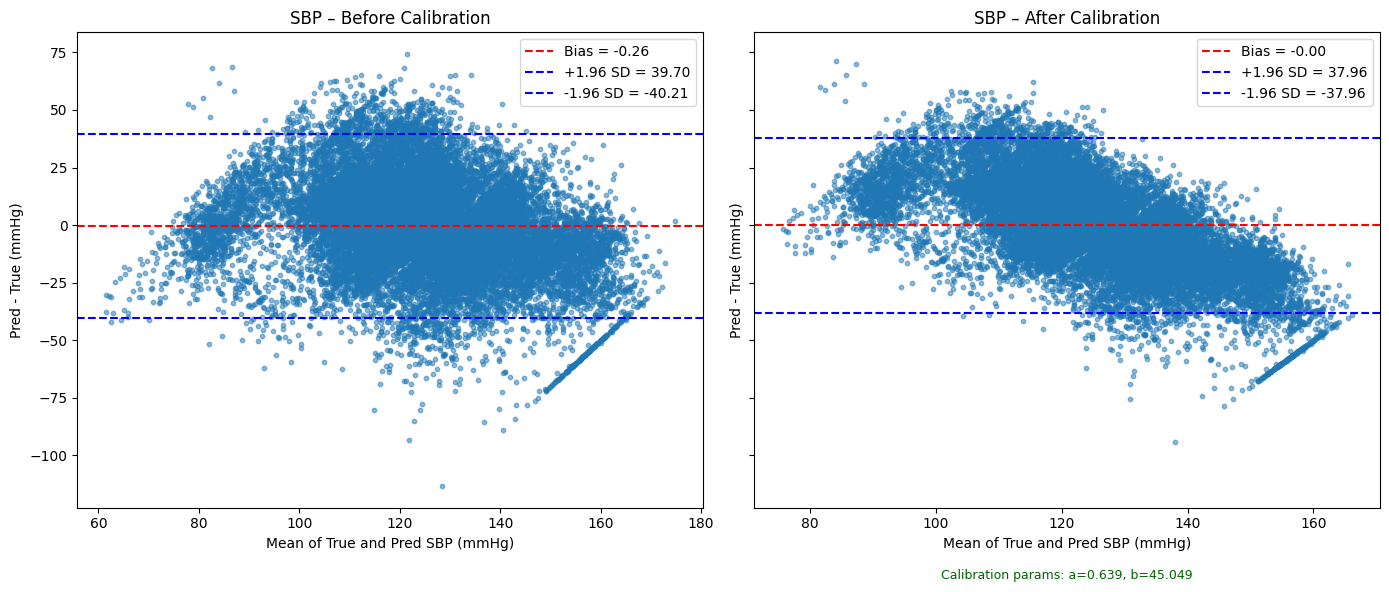

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman(true, pred, title, ax, calib_params=None):
    mean_vals = (true + pred) / 2
    diff = pred - true

    mean_diff = np.mean(diff)
    std_diff  = np.std(diff, ddof=1)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff

    ax.scatter(mean_vals, diff, alpha=0.5, s=10)
    ax.axhline(mean_diff, color="red", linestyle="--", label=f"Bias = {mean_diff:.2f}")
    ax.axhline(loa_upper, color="blue", linestyle="--", label=f"+1.96 SD = {loa_upper:.2f}")
    ax.axhline(loa_lower, color="blue", linestyle="--", label=f"-1.96 SD = {loa_lower:.2f}")
    ax.set_title(title)
    ax.set_xlabel("Mean of True and Pred SBP (mmHg)")
    ax.set_ylabel("Pred - True (mmHg)")

    # Add calibration params if provided
    if calib_params is not None:
        param_text = ", ".join([f"{k}={v:.3f}" for k, v in calib_params.items() if k in ["a","b","c"]])
        ax.text(
            0.5, -0.15, f"Calibration params: {param_text}", 
            transform=ax.transAxes, ha="center", fontsize=9, color="darkgreen"
        )

    ax.legend()

def plot_bland_altman_pre_post(df, calib_params=None):
    fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

    bland_altman(
        df["true_sbp"].values, 
        df["pred_sbp"].values, 
        "SBP – Before Calibration", 
        axes[0]
    )
    bland_altman(
        df["true_sbp"].values, 
        df["pred_sbp_cal"].values, 
        "SBP – After Calibration", 
        axes[1],
        calib_params=calib_params
    )

    plt.tight_layout()
    plt.show()

# Example usage
plot_bland_altman_pre_post(df_aug, calib_params=calib)


---------------------